## Data Processing -- Topic Modeling -- Topic Merging -- Base Popularity -- Global topic info

In [1]:
import os
import re
import math
import time
import pickle
import numpy as np
import pandas as pd
import logging

# Keep BERTopic logs minimal
logging.getLogger("BERTopic").setLevel(logging.ERROR)

!pip install bertopic umap-learn hdbscan openpyxl --quiet
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================
# STEP A: LOAD & SPLIT
# ==========================================
def load_and_filter_data(csv_path: str):
    """
    1) Loads CSV
    2) Filters relevant articles (document_type=article, news_desk=Business)
    3) Splits into train & eval:
       Train: 2021-06-01 <= pub_date < 2022-04-01
       Eval:  2022-04-01 <= pub_date <= 2022-06-30
    """
    df = pd.read_csv(csv_path, low_memory=True)
    df['pub_date'] = pd.to_datetime(df['pub_date'], errors='coerce')
    df.dropna(subset=['pub_date'], inplace=True)

    # Basic filtering
    df = df[df['document_type'] == "article"]
    df = df[df['news_desk'] == 'Business']
    df['lead_paragraph'] = df['lead_paragraph'].astype(str)
    df = df[df['lead_paragraph'].str.len() >= 100]
    df = df[~df['lead_paragraph'].str.fullmatch(r'_+')]
    df = df[['pub_date', 'lead_paragraph']]

    # Train vs Eval
    train_mask = (df['pub_date'] >= '2021-06-01') & (df['pub_date'] < '2022-04-01')
    eval_mask  = (df['pub_date'] >= '2022-04-01') & (df['pub_date'] <= '2022-06-30')
    train_df = df[train_mask].copy()
    eval_df  = df[eval_mask].copy()

    print(f"[Load & Filter] Train={train_df.shape} rows, Eval={eval_df.shape} rows.")
    return train_df, eval_df

# ==========================================
# STEP B: SLICE & PREPROCESS
# ==========================================
def slice_monthly(df, date_col='pub_date', text_col='lead_paragraph'):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df.dropna(subset=[date_col], inplace=True)
    df['year_month'] = df[date_col].dt.to_period('M').astype(str)
    slices = {}
    for ym, grp in df.groupby('year_month'):
        slices[ym] = grp.reset_index(drop=True)
    return slices

def simple_clean(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_slices(month_slices, text_col='lead_paragraph'):
    out = {}
    for ym, df_ in month_slices.items():
        temp = df_.copy()
        temp[text_col] = temp[text_col].apply(simple_clean)
        out[ym] = temp
    return out

# ==========================================
# STEP C: BERTopic per Month
# ==========================================
def run_bertopic_pipeline(month_slices, text_col='lead_paragraph', model_dir="models"):
    os.makedirs(model_dir, exist_ok=True)

    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=2, min_samples=1, metric="euclidean")

    monthly_results = {}
    doc_info_list = []

    sorted_months = sorted(month_slices.keys())
    for ym in sorted_months:
        subdf = month_slices[ym]
        docs = subdf[text_col].tolist()
        if not docs:
            print(f"[BERTopic] {ym} => No docs => skip.")
            monthly_results[ym] = {}
            continue

        print(f"\n[BERTopic] {ym}, docs={len(docs)}")
        tm = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=False)
        topics, _ = tm.fit_transform(docs)

        model_path = os.path.join(model_dir, f"BERTopic_{ym}.pkl")
        tm.save(model_path)
        unique_topics = len(set(topics))
        print(f" -> Found {unique_topics} unique topics (inc. -1). Model => {model_path}")

        # Build doc->topic map
        topic_doc_map = {}
        for i, t_id in enumerate(topics):
            topic_doc_map.setdefault(t_id, []).append(i)

        # Create short labels/titles for each local topic
        topic_titles = {}
        all_topic_ids = set(topics)
        for t_id in all_topic_ids:
            if t_id == -1:
                topic_titles[t_id] = "Outlier/Noise"
            else:
                top_words = tm.get_topic(t_id)  # list of (word, weight)
                if not top_words:
                    topic_titles[t_id] = f"Topic_{t_id}"
                else:
                    top3_words = [word for word, weight in top_words[:3]]
                    short_label = "_".join(top3_words)
                    topic_titles[t_id] = short_label

        # Get document info from BERTopic
        di = tm.get_document_info(docs)
        di['month'] = ym
        di['doc_index_in_month'] = di.index
        di['original_text'] = subdf[text_col]
        doc_info_list.append(di)

        monthly_results[ym] = {
            "model_path": model_path,
            "topics": topics,
            "topic_doc_map": topic_doc_map,
            "df": subdf,
            "topic_titles": topic_titles
        }

    combined_df = pd.concat(doc_info_list, ignore_index=True) if doc_info_list else pd.DataFrame()
    return monthly_results, combined_df

# ==========================================
# STEP D: MERGE & POPULARITY
# ==========================================
def merge_monthly_topics(
    monthly_results: dict,
    similarity_threshold: float = 0.7,
    date_col: str = 'pub_date',
    text_col: str = 'lead_paragraph'
) -> dict:
    """
    Merges monthly topics incrementally, following Boutaleb et al. (2024):
      - For each new topic embedding c_j^{t+1}, compare with all global topics c_k^t.
      - If max similarity >= threshold, merge (append docs and local title) into that global topic.
      - Else create a new global topic with the local title.
      
    Global structure:
      global_topics = {
         global_tid: {
           'embedding': np.array,
           'months_docs': List[(month, local_doc_idx)],
           'first_month': str,
           'global_topic_titles': List[str]  # local titles contributing to this global topic
         }
      }
      
    Returns:
      merge_output: { "global_topics": ..., "merge_timeline": ... }
    """
    global_topics = {}
    global_tid_counter = 0
    merge_timeline = {}
    sorted_months = sorted(monthly_results.keys())

    for month_key in sorted_months:
        if 'topics' not in monthly_results[month_key]:
            merge_timeline[month_key] = {}
            continue

        print(f"\n[MERGE] Processing month={month_key}")
        model_path = monthly_results[month_key]['model_path']
        if not os.path.exists(model_path):
            print(f" Model file not found: {model_path}, skipping.")
            merge_timeline[month_key] = {}
            continue

        from bertopic import BERTopic
        topic_model = BERTopic.load(model_path)
        if getattr(topic_model, "topic_embeddings_", None) is None:
            print(f" No topic_embeddings_ found for {month_key}, skipping merges.")
            merge_timeline[month_key] = {}
            continue

        local_doc_map = monthly_results[month_key]['topic_doc_map']
        local_tids = sorted(local_doc_map.keys())
        local_embeddings = topic_model.topic_embeddings_
        local_titles = monthly_results[month_key].get("topic_titles", {})

        valid_local_tids = [t for t in local_tids if t != -1 and t < len(local_embeddings)]
        month_merge_result = {}

        for ltid in valid_local_tids:
            ltid_embedding = local_embeddings[ltid].reshape(1, -1)
            local_title = local_titles.get(ltid, f"Topic_{ltid}")
            best_sim = -1
            best_global_tid = None

            for g_tid, g_info in global_topics.items():
                global_emb = g_info['embedding'].reshape(1, -1)
                sim_val = cosine_similarity(ltid_embedding, global_emb)[0][0]
                if sim_val > best_sim:
                    best_sim = sim_val
                    best_global_tid = g_tid

            if best_sim >= similarity_threshold and best_global_tid is not None:
                for doc_idx in local_doc_map[ltid]:
                    global_topics[best_global_tid]['months_docs'].append((month_key, doc_idx))
                month_merge_result.setdefault(best_global_tid, []).extend(
                    [(month_key, idx) for idx in local_doc_map[ltid]]
                )
                global_topics[best_global_tid]['global_topic_titles'].append(local_title)
            else:
                global_topics[global_tid_counter] = {
                    'embedding': ltid_embedding[0],
                    'months_docs': [(month_key, x) for x in local_doc_map[ltid]],
                    'first_month': month_key,
                    'global_topic_titles': [local_title]
                }
                month_merge_result[global_tid_counter] = [
                    (month_key, idx) for idx in local_doc_map[ltid]
                ]
                global_tid_counter += 1

        merge_timeline[month_key] = month_merge_result

    merge_output = {
        "global_topics": global_topics,
        "merge_timeline": merge_timeline
    }
    return merge_output

def compute_base_popularity(
    merge_output: dict,
    monthly_results: dict,
    decay_factor: float = 0.01
) -> pd.DataFrame:
    """
    Implements the frequency-plus-decay popularity metric:
      p_t^k = p_{t-1}^k + (# new docs)  if updated,
      else p_t^k = p_{t-1}^k * exp(-decay_factor * delta^2)
    Returns a DataFrame tracking monthly popularity:
      [ 'month', 'global_topic_id', 'popularity' ]
    """
    global_topics = merge_output['global_topics']
    timeline = merge_output['merge_timeline']
    sorted_months = sorted(monthly_results.keys())
    popularity_dict = {}
    last_update_month_idx = {}
    all_global_tids = list(global_topics.keys())

    for g_tid in all_global_tids:
        popularity_dict[g_tid] = {}
        last_update_month_idx[g_tid] = -1

    rows = []
    month_to_index = {m: i for i, m in enumerate(sorted_months)}

    for m_idx, m_key in enumerate(sorted_months):
        updated_tids = timeline[m_key].keys()
        for g_tid in all_global_tids:
            old_pop = 0.0 if m_idx == 0 else popularity_dict[g_tid].get(sorted_months[m_idx-1], 0.0)
            if g_tid in updated_tids:
                docs_added = len(timeline[m_key][g_tid])
                new_pop = old_pop + docs_added
                last_update_month_idx[g_tid] = m_idx
            else:
                old_update = last_update_month_idx[g_tid]
                new_pop = 0.0 if old_update < 0 else old_pop * math.exp(-decay_factor * ((m_idx - old_update) ** 2))
            popularity_dict[g_tid][m_key] = new_pop
            rows.append({
                "month": m_key,
                "global_topic_id": g_tid,
                "popularity": new_pop
            })

    pop_df = pd.DataFrame(rows)
    return pop_df

def gather_global_topic_info(merge_output, combined_doc_info):
    """
    For each global topic in merge_output, this function retrieves the corresponding document
    information from combined_doc_info (obtained via tm.get_document_info). The resulting DataFrame
    includes:
      - global_topic_id: The unified ID for the topic.
      - global_topic_title: A string (joined from local titles) for the global topic.
      - month: The month from which the document comes.
      - local_doc_idx: The document index within that month.
      - All additional columns from combined_doc_info.
      - dataset_type: Indicator for 'train' or 'eval'.
    """
    import pandas as pd
    rows = []
    global_topics = merge_output["global_topics"]

    for g_tid, g_info in global_topics.items():
        global_title = "; ".join(g_info.get("global_topic_titles", []))
        for (month_key, local_doc_idx) in g_info.get("months_docs", []):
            match = combined_doc_info[
                (combined_doc_info['month'] == month_key) &
                (combined_doc_info['doc_index_in_month'] == local_doc_idx)
            ]
            if not match.empty:
                for _, doc_row in match.iterrows():
                    doc_dict = doc_row.to_dict()
                    doc_dict["global_topic_id"] = g_tid
                    doc_dict["global_topic_title"] = global_title
                    rows.append(doc_dict)
            else:
                print(f"Warning: No document found for month {month_key}, index {local_doc_idx}")
    final_df = pd.DataFrame(rows)
    return final_df

# ==========================================
# STEP E: MAIN PIPELINE
# ==========================================
def main_pipeline(csv_path, out_dir="results_final", similarity_threshold=0.7, decay_factor=0.01):
    os.makedirs(out_dir, exist_ok=True)
    start = time.time()

    # 1) Load & Filter Data
    train_df, eval_df = load_and_filter_data(csv_path)

    # 2) Training Pipeline
    print("\n[TRAINING PIPELINE]")
    train_slices = slice_monthly(train_df)
    train_cleaned = preprocess_slices(train_slices)
    train_model_dir = os.path.join(out_dir, "train_models")
    tr_results, tr_docinfo = run_bertopic_pipeline(train_cleaned, model_dir=train_model_dir)

    tr_merged = merge_monthly_topics(monthly_results=tr_results, similarity_threshold=similarity_threshold)
    train_pop = compute_base_popularity(merge_output=tr_merged, monthly_results=tr_results, decay_factor=decay_factor)

    # Save training doc info and popularity
    train_doc_xlsx = os.path.join(out_dir, "train_doc_info.xlsx")
    train_pop_xlsx = os.path.join(out_dir, "train_popularity.xlsx")
    tr_docinfo.to_excel(train_doc_xlsx, index=False)
    train_pop.to_excel(train_pop_xlsx, index=False)
    print(f" [Train] doc info => {train_doc_xlsx} shape={tr_docinfo.shape}")
    print(f" [Train] popularity => {train_pop_xlsx} shape={train_pop.shape}")

    # 3) Evaluation Pipeline
    print("\n[EVALUATION PIPELINE]")
    eval_slices = slice_monthly(eval_df)
    eval_cleaned = preprocess_slices(eval_slices)
    eval_model_dir = os.path.join(out_dir, "eval_models")
    ev_results, ev_docinfo = run_bertopic_pipeline(eval_cleaned, model_dir=eval_model_dir)

    ev_merged = merge_monthly_topics(monthly_results=ev_results, similarity_threshold=similarity_threshold)
    eval_pop = compute_base_popularity(merge_output=ev_merged, monthly_results=ev_results, decay_factor=decay_factor)

    # Save evaluation doc info and popularity
    eval_doc_xlsx = os.path.join(out_dir, "eval_doc_info.xlsx")
    eval_pop_xlsx = os.path.join(out_dir, "eval_popularity.xlsx")
    ev_docinfo.to_excel(eval_doc_xlsx, index=False)
    eval_pop.to_excel(eval_pop_xlsx, index=False)
    print(f" [Eval] doc info => {eval_doc_xlsx} shape={ev_docinfo.shape}")
    print(f" [Eval] popularity => {eval_pop_xlsx} shape={eval_pop.shape}")

    # ------------------------------
    # New: Gather Global Topic Document Info
    # ------------------------------
    # Add a dataset_type column to each doc_info DataFrame
    tr_docinfo['dataset_type'] = 'train'
    ev_docinfo['dataset_type'] = 'eval'

    global_topic_doc_info_train = gather_global_topic_info(tr_merged, tr_docinfo)
    global_topic_doc_info_eval  = gather_global_topic_info(ev_merged, ev_docinfo)
    global_topic_doc_info = pd.concat([global_topic_doc_info_train, global_topic_doc_info_eval], ignore_index=True)

    # ------------------------------
    # 4) Return dicts needed for advanced metrics
    # ------------------------------
    final_output = {
        "train_monthly_data": train_cleaned,
        "train_merge_output": tr_merged,
        "train_monthly_results": tr_results,
        "train_popularity": train_pop,
        "eval_monthly_data": eval_cleaned,
        "eval_merge_output": ev_merged,
        "eval_monthly_results": ev_results,
        "eval_popularity": eval_pop,
        "global_topic_doc_info": global_topic_doc_info
    }

    pkl_path = os.path.join(out_dir, "final_output.pkl")
    with open(pkl_path, "wb") as f:
        pickle.dump(final_output, f)
    print(f"\n[Done] entire pipeline => saved pickle {pkl_path}")
    print(f"[Total time] = {time.time()-start:.2f}s")
    return final_output


In [ ]:
if __name__ == "__main__":
    CSV_PATH = "../filtered_data_after_2020.csv"
    out_folder = "results_final"
    out = main_pipeline(
        csv_path=CSV_PATH,
        out_dir=out_folder,
        similarity_threshold=0.7,
        decay_factor=0.01
    )

## Load result

In [54]:
import os
import re
import math
import time
import pickle
import numpy as np
import pandas as pd
import logging

def load_final_output(pickle_path: str):
    """
    Loads the entire `final_output` dictionary from the specified pickle path.
    Returns a dictionary containing:
      - "train_monthly_data", "train_merge_output", "train_monthly_results", "train_popularity"
      - "eval_monthly_data", "eval_merge_output", "eval_monthly_results", "eval_popularity"
    """
    with open(pickle_path, "rb") as f:
        final_out = pickle.load(f)
    print(f"[Load] final_output loaded from {pickle_path}")
    # Optional: display keys for debugging
    print("Keys in final_out:", list(final_out.keys()))
    return final_out

if __name__ == "__main__":
    pkl_path = "results_final/final_output.pkl"
    result = load_final_output(pkl_path)
    print("Train popularity shape:", result["train_popularity"].shape)





[Load] final_output loaded from results_final/final_output.pkl
Keys in final_out: ['train_monthly_data', 'train_merge_output', 'train_monthly_results', 'train_popularity', 'eval_monthly_data', 'eval_merge_output', 'eval_monthly_results', 'eval_popularity', 'global_topic_doc_info']
Train popularity shape: (6520, 3)


## Topic selection -- Ground Truth approach

In [ ]:
tr_info = pd.read_excel("results_final/train_doc_info.xlsx")
eval_info = pd.read_excel("results_final/eval_doc_info.xlsx")

def select_top_docs_by_topic(train_df, eval_df, top_k_topics=3, top_n_docs=5):
    """
    This function selects, for each month, the topics with the highest document count 
    (excluding Topic == -1) from two DataFrames (train and eval). For each month:
      a) Group the data by 'month' and exclude rows with Topic == -1.
      b) Count the number of documents assigned to each topic.
      c) Select the top_k_topics (default=3) based solely on document count.
      d) For each selected topic, sort the documents by 'Probability' in descending order,
         drop duplicate documents based on the "Document" column, and then select up to 
         top_n_docs (default=5). (If fewer than top_n_docs exist, all available documents are accepted.)
      e) Label each row with a 'dataset_type' column indicating whether it comes from the 
         training set ('train') or evaluation set ('eval').
    Finally, the function concatenates the results from both datasets and returns a combined DataFrame.
    
    Args:
        train_df (pd.DataFrame): Training document info DataFrame, with columns such as 
            ['Document', 'Topic', 'Probability', 'month', ...].
        eval_df (pd.DataFrame): Evaluation document info DataFrame with the same structure.
        top_k_topics (int): Number of topics to select per month (by document count).
        top_n_docs (int): Maximum number of distinct documents to keep per topic (by highest 'Probability').
    
    Returns:
        pd.DataFrame: Combined DataFrame containing documents from the top topics per month,
                      with a 'dataset_type' column indicating their source.
    """
    import pandas as pd

    def process_one_set(df_in, dataset_label):
        result_list = []
        
        # Group by month
        for month_key, group_df in df_in.groupby('month'):
            # Exclude rows with Topic == -1
            valid_df = group_df[group_df['Topic'] != -1]
            if valid_df.empty:
                continue
            
            # Count documents per topic
            topic_counts = valid_df['Topic'].value_counts()
            # Pick top_k_topics based on document count
            top_topics = topic_counts.index[:top_k_topics].tolist()
            
            # For each selected topic, select distinct top_n_docs based on highest Probability
            for topic_id in top_topics:
                topic_subset = valid_df[valid_df['Topic'] == topic_id].copy()
                topic_subset = topic_subset.sort_values('Probability', ascending=False)
                # Drop duplicates based on the "Document" column
                topic_subset = topic_subset.drop_duplicates(subset=["Document"])
                top_n_subset = topic_subset.head(top_n_docs).copy()
                top_n_subset['dataset_type'] = dataset_label
                result_list.append(top_n_subset)
        
        if result_list:
            return pd.concat(result_list, ignore_index=True)
        else:
            return pd.DataFrame()

    # Process training and evaluation DataFrames
    train_top = process_one_set(train_df, 'train')
    eval_top = process_one_set(eval_df, 'eval')
    
    # Combine results
    final_df = pd.concat([train_top, eval_top], ignore_index=True)
    return final_df



# g_t_df stands for ground trurth dataframe 
g_t_df = select_top_docs_by_topic(train_df = tr_info, eval_df= eval_info, top_k_topics=3, top_n_docs=5)

g_t_df.to_excel("refined_topics/select_top_docs_by_topic.xlsx", index=False)

import os
import json
import pandas as pd

def create_refinement_prompts(g_r_df, output_dir="refined_topics"):
    """
    Generates JSON prompt files for GPT O3 refinement. Each JSON includes:
      - 'prompt': instructions for GPT
      - 'topic_info': a dict with { 'month', 'topic_id', 'topic_name' }
      - 'documents': a list of up to 5 docs, each containing the text and any relevant columns

    We group by (month, Topic), which should yield 39 groups if you have 13 months × 3 topics.
    Each group has 5 documents. For each group, we create one JSON file named:
      month_<MONTH>_topic_<TOPIC>.json

    The user can then feed each JSON to GPT O3 for step-2 refinement.

    Args:
        g_r_df (pd.DataFrame):
          DataFrame with columns at least:
            ['Document', 'Topic', 'Name', 'Probability', 'month', ...]
          - "Document": The text of each document
          - "Name": The short label/title for the local topic
          - "Topic": The numeric ID
          - "month": The month string
          - Additional columns can be included if needed
        output_dir (str): 
          Directory where JSON files will be stored.
    """

    os.makedirs(output_dir, exist_ok=True)

    # Group by (month, Topic)
    grouped = g_r_df.groupby(["month", "Topic"], as_index=False)

    for (month_val, topic_val), group in grouped:
        # Retrieve the topic title from the first row's 'Name' column
        topic_name = group["Name"].iloc[0]

        # Build a list of up to 5 documents
        docs_list = []
        for _, row in group.iterrows():
            docs_list.append({
                "Document": row["Document"],
                "probability": float(row.get("Probability", 0.0)),
                # Add other fields as desired, e.g. 'dataset_type'
            })

        # Create the prompt text for GPT O3
        prompt_text = (
        "We have a topic from the given month and 5 relevant documents.\n\n"
        "Task:\n"
        "1) Provide a 'refined_topic' (must be between 4 to 8 words) description that summarizes the main ideas/themes.\n"
        "2) Provide a section explaining how an expert might validate or interpret this refined topic.\n"
        "3) Include the keys 'month' and 'topic_id' in your output to reflect the given month and topic identifier.\n\n"
        "Output your answer in JSON with keys: 'refined_topic', 'month', and 'topic_id'.\n"
        "Focus on new or emerging ideas across these documents that shape the final summary.\n"
        )


        # Construct the JSON structure
        out_json = {
            "prompt": prompt_text,
            "topic_info": {
                "month": str(month_val),
                "topic_id": int(topic_val),
                "topic_name": str(topic_name)
            },
            "documents": docs_list
        }

        # Build a filename like month_2021-06_topic_2.json
        filename = f"month_{month_val}_topic_{topic_val}.json"
        filepath = os.path.join(output_dir, filename)

        # Save as JSON
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(out_json, f, ensure_ascii=False, indent=2)

        print(f"Saved: {filepath}")


# API code
import os
import json
import openai
import pandas as pd

# Set  OpenAI API key 
openai.api_key = os.environ.get("OPENAI_API_KEY")

def call_gpt_for_refinement(json_filepath, model="gpt-3.5-turbo", temperature=0.2):
    """
    Reads a JSON prompt file, sends its content to GPT via the OpenAI API,
    and returns the parsed JSON response containing the refined topic.
    
    Args:
        json_filepath (str): Path to the JSON prompt file.
        model (str): GPT model to use.
        temperature (float): Sampling temperature for the API call.
    
    Returns:
        dict: The refined output as a dictionary (with keys 'refined_topic', 
             'month', and 'topic_id'), or an error message.
    """
    with open(json_filepath, "r", encoding="utf-8") as f:
        prompt_data = json.load(f)
    
    # Build the message; we include the entire JSON prompt as the user message.
    messages = [
        {"role": "system", "content": "You are GPT O3, a topic refinement assistant."},
        {"role": "user", "content": json.dumps(prompt_data)}
    ]
    
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=200
    )
    reply = response.choices[0].message.content
    try:
        refined_result = json.loads(reply)
    except Exception as e:
        print(f"Error parsing JSON for {json_filepath}: {e}")
        refined_result = {"error": reply}
    return refined_result

def process_all_refinement_prompts(input_dir="refined_topics", output_dir="refined_results"):
    """
    Iterates over all JSON prompt files in the input_dir, calls the GPT API for each,
    saves each refined result as a JSON file in output_dir, and collects all results
    into a single DataFrame.
    
    Each refined result includes the keys 'refined_topic', 
    'month', and 'topic_id'. The original topic info (month, topic_id, topic_name) from the
    prompt is also attached.
    
    Args:
        input_dir (str): Directory containing the JSON prompt files.
        output_dir (str): Directory where refined result JSON files will be saved.
    
    Returns:
        pd.DataFrame: A DataFrame containing the refined results from all prompts.
    """
    os.makedirs(output_dir, exist_ok=True)
    results = []
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".json"):
            filepath = os.path.join(input_dir, filename)
            refined_result = call_gpt_for_refinement(filepath)
            
            # Save the refined result as a JSON file
            out_filename = f"refined_{filename}"
            out_filepath = os.path.join(output_dir, out_filename)
            with open(out_filepath, "w", encoding="utf-8") as f:
                json.dump(refined_result, f, ensure_ascii=False, indent=2)
            
            # Read the original prompt to attach meta information
            with open(filepath, "r", encoding="utf-8") as f:
                prompt_data = json.load(f)
            refined_result["month"] = prompt_data["topic_info"]["month"]
            refined_result["topic_id"] = prompt_data["topic_info"]["topic_id"]
            refined_result["topic_name"] = prompt_data["topic_info"]["topic_name"]
            results.append(refined_result)
            print(f"Processed: {filename}")
    
    df_results = pd.DataFrame(results)
    return df_results

df_refined = process_all_refinement_prompts(input_dir="refined_topics", output_dir="refined_results")
df_refined.to_excel("refined_results.xlsx", index=False)


In [ ]:
create_refinement_prompts(g_t_df, output_dir="refined_topics")

In [6]:
refined_topics_df = pd.DataFrame(refined_topics_df)

In [7]:
refined_topics_df.to_excel("refined_topics/refined_topics_output.xlsx", index=False)

## Relevance -- Novelty -- Velocity Functions

In [9]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import Dict, List
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def compute_relevance(
    merge_output: dict,
    monthly_data: dict,
    text_col: str = "lead_paragraph",
    embedding_model_name: str = "all-mpnet-base-v2",
    device: str = "cpu"
) -> pd.DataFrame:
    """
    Computes Relevance (R_t^k) for each topic-month pair, following Mimno et al. (2011)
    and Sridhar (2018). Relevance measures how semantically central a topic is to the
    entire monthly corpus. Concretely:

      R_t^k = (1 / |D_t|) * sum_{x in D_t} [cosine_sim(c_t^k, e_x)]

    Steps:
      1) Encode all documents in month t with Sentence-BERT (or similar).
      2) For each global topic that has docs in month t:
         - Gather those doc embeddings and compute centroid (topic embedding).
         - Compare the centroid to ALL doc embeddings in month t with cosine similarity.
         - Average the similarity => Relevance score for that topic-month.
      3) Return a DataFrame containing columns:
         [ 'month', 'global_topic_id', 'relevance' ].

    Args:
      merge_output (dict): 
        The result of Step 4. Must contain:
          merge_output["global_topics"] and merge_output["merge_timeline"].
        'global_topics'[global_tid] has 'months_docs': list of (month_str, doc_idx_in_month).
      monthly_data (dict): 
        The dictionary from Step 1 (or after cleaning in Step 2): 
        { 'YYYY-MM': DataFrame for that month }, containing the text_col.
      text_col (str): 
        The column name in monthly_data DataFrame that stores (cleaned) document text.
      embedding_model_name (str): 
        Name of the SentenceTransformer model (default "all-mpnet-base-v2").
      device (str): 
        "cpu" or "cuda" for faster embedding on GPU.

    Returns:
      pd.DataFrame with columns:
        [ 'month', 'global_topic_id', 'relevance' ]

    References:
      - Mimno et al. (2011), Sridhar (2018): Centroid-based semantic representations.
      - Zhao et al. (2023): sub-centroids method (not implemented here, but could be extended).
    """

    # 1) Prepare the Sentence-BERT embedding model
    embedder = SentenceTransformer(embedding_model_name, device=device)

    # 2) Store results in a list of rows
    relevance_rows = []

    # 3) Sort months for consistency
    sorted_months = sorted(monthly_data.keys())

    # For convenience, we'll build a structure to store doc embeddings by month
    # doc_embeddings_by_month[month] = np.array of shape (#docs_in_month, embedding_dim)
    doc_embeddings_by_month = {}

    # Also store a list of doc texts for each month so we know which doc_idx -> text
    # (If you have them already in step 2 or 3, adapt as needed.)
    for m_key in sorted_months:
        df_month = monthly_data[m_key]
        if df_month.empty:
            doc_embeddings_by_month[m_key] = np.zeros((0, 768))  # or appropriate dim
            continue
        texts = df_month[text_col].tolist()

        # Encode all docs in this month
        embeddings = embedder.encode(texts, convert_to_tensor=False, show_progress_bar=False)
        doc_embeddings_by_month[m_key] = np.array(embeddings)

    # 4) Next, retrieve the global topics from merge_output
    global_topics = merge_output["global_topics"]

    # 5) For each month, we want to find which global topics have docs in that month,
    #    compute centroid, then average cos sim to all docs in that month.
    for m_key in tqdm(sorted_months, desc="Computing Relevance per month"):
        all_month_embeddings = doc_embeddings_by_month.get(m_key, None)
        if all_month_embeddings is None or len(all_month_embeddings) == 0:
            # No docs => skip
            continue

        # Build a map: topic_id -> list_of_doc_embeddings (for that topic in this month)
        # We'll do so by checking each global topic's 'months_docs' references.
        # Alternatively, we could also look at merge_output["merge_timeline"][m_key].
        # But "global_topics" is more direct for storing the embedding.

        for g_tid, g_info in global_topics.items():
            # Filter for docs that belong to (m_key)
            relevant_docs = [
                (mon, idx) for (mon, idx) in g_info["months_docs"] if mon == m_key
            ]
            if len(relevant_docs) == 0:
                # This topic has no docs in month m_key => no relevance
                # (We might store 0 or skip.)
                continue

            # Gather embeddings for these docs
            # doc_idx_in_month -> all_month_embeddings[doc_idx_in_month]
            doc_embs = []
            for (_, local_doc_idx) in relevant_docs:
                if 0 <= local_doc_idx < all_month_embeddings.shape[0]:
                    doc_embs.append(all_month_embeddings[local_doc_idx])

            if len(doc_embs) == 0:
                # No valid embeddings => skip
                continue

            doc_embs = np.array(doc_embs)
            # 6) Compute centroid c_t^k
            centroid = doc_embs.mean(axis=0)  # shape: (embedding_dim,)

            # 7) Compute average cosine similarity to all docs in month m_key
            sims = cosine_similarity([centroid], all_month_embeddings)[0]  # shape: (#docs_in_month,)
            relevance_score = sims.mean()

            # 8) Store result
            relevance_rows.append({
                "month": m_key,
                "global_topic_id": g_tid,
                "relevance": relevance_score
            })

    # Build final DataFrame
    relevance_df = pd.DataFrame(relevance_rows)

    # Return or save this as needed
    return relevance_df


In [10]:
import os
import re
from typing import Dict, List
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict
from scipy.stats import entropy

def compute_novelty(
    merge_output: dict,
    monthly_data: dict,
    text_col: str = "lead_paragraph",
    kl_smoothing: float = 1e-9
) -> pd.DataFrame:
    """
    Computes "Novelty" (N_t^k) for each global topic in each month, 
    as per Leskovec et al. (2009), Sayyadi et al. (2009), Virtanen et al. (2020).
    
    We represent each topic's distribution P_t^k as a bag-of-words distribution
    across all docs that topic holds in month t, then compute KL divergence:
        N_t^k = KL( P_t^k || P_{t-1}^k )
    If the topic did not exist in t-1 => set novelty to a high value 
    (e.g., indicating a "completely new" topic).
    
    Steps:
      1) For each month, for each global topic -> gather all doc texts from 'months_docs'.
      2) Tokenize & build a bag-of-words frequency distribution => normalize => "dist_t".
      3) Find the same global topic's distribution in t-1 => "dist_(t-1)".
      4) N_t^k = KL( dist_t || dist_(t-1) ), if dist_(t-1) exists, else "max" or a large constant.
      5) Return a DataFrame: [ 'month', 'global_topic_id', 'novelty' ].
    
    Args:
      merge_output (dict):
        the dictionary from Step 4 with:
          - global_topics: { g_tid: { 'months_docs': [ (month, doc_idx), ...], ... } }
          - merge_timeline: ...
      monthly_data (dict):
        same structure from earlier steps: { 'YYYY-MM': DataFrame of that month }
      text_col (str):
        name of column containing the final (cleaned) text
      kl_smoothing (float):
        small constant added to counts to avoid log(0) in KL divergence.

    Returns:
      pd.DataFrame with columns:
        [ 'month', 'global_topic_id', 'novelty' ]

    References:
      - Leskovec et al. (2009), Sayyadi et al. (2009): concept of distribution-based novelty.
      - Virtanen et al. (2020): for advanced distribution manipulations.
      - Arjovsky et al. (2017), Shen et al. (2023): if you prefer Wasserstein distance instead of KL.
    """

    # 1) Sort months for consistency
    sorted_months = sorted(monthly_data.keys())

    # 2) Prepare data structures to hold bag-of-words distributions
    #    We'll store for each (g_tid, month) a normalized distribution: { word -> prob }
    topic_distributions = {}

    # Helper function to tokenize a text. You could do more sophisticated tokenization
    def simple_tokenize(text: str):
        return re.findall(r"\w+", text.lower())

    # 3) Build distribution for each global topic in each month
    global_topics = merge_output["global_topics"]

    for m_key in tqdm(sorted_months, desc="Building Bag-of-Words"):
        # Retrieve that month's data
        if m_key not in monthly_data:
            continue
        df_month = monthly_data[m_key]
        if df_month.empty:
            continue

        # We'll handle each global topic
        for g_tid, g_info in global_topics.items():
            # Filter for docs in this month
            docs_in_month = [
                doc_idx for (mon, doc_idx) in g_info["months_docs"] if mon == m_key
            ]
            if len(docs_in_month) == 0:
                # No documents => skip
                continue

            # Build bag-of-words
            word_counter = Counter()
            for doc_idx in docs_in_month:
                if 0 <= doc_idx < len(df_month):
                    text = str(df_month.iloc[doc_idx][text_col])
                    tokens = simple_tokenize(text)
                    word_counter.update(tokens)

            # Turn counts into distribution
            total_count = sum(word_counter.values()) + kl_smoothing * len(word_counter)
            dist_map = {}
            for w, c in word_counter.items():
                dist_map[w] = (c + kl_smoothing) / total_count

            topic_distributions[(g_tid, m_key)] = dist_map

    # 4) For each topic-month, compare to previous month => compute KL divergence
    #    If there's no data from t-1 => set novelty to a large # or skip
    novelty_rows = []

    month_index_map = {m: i for i, m in enumerate(sorted_months)}

    def compute_kl(dist_t, dist_prev, smoothing):
        """
        KL(dist_t || dist_prev):
          sum( dist_t[w] * log( dist_t[w] / dist_prev[w] ) )
        We handle words from both distributions by union of keys,
        with smoothing to avoid zero. 
        """
        # Combine keys
        all_keys = set(dist_t.keys()) | set(dist_prev.keys())
        kl_val = 0.0
        for w in all_keys:
            p_t = dist_t.get(w, smoothing)
            p_prev = dist_prev.get(w, smoothing)
            # sum( p_t * log( p_t / p_prev ) )
            kl_val += p_t * np.log(p_t / p_prev)
        return kl_val

    for m_key in tqdm(sorted_months, desc="Computing Novelty"):
        for g_tid, g_info in global_topics.items():
            # If this topic doesn't appear in month m_key => skip
            if (g_tid, m_key) not in topic_distributions:
                continue

            # If there's no previous month or the topic didn't appear in the previous month, 
            # we can treat it as max novelty or a high number
            m_idx = month_index_map[m_key]
            if m_idx == 0:
                # first month => no prior month
                novelty_val = 999.0  # or any "large" placeholder
            else:
                prev_m_idx = m_idx - 1
                prev_month = sorted_months[prev_m_idx]
                # Check if the distribution for the same g_tid in prev_month exists
                if (g_tid, prev_month) not in topic_distributions:
                    novelty_val = 999.0
                else:
                    dist_t = topic_distributions[(g_tid, m_key)]
                    dist_prev = topic_distributions[(g_tid, prev_month)]
                    novelty_val = compute_kl(dist_t, dist_prev, kl_smoothing)

            novelty_rows.append({
                "month": m_key,
                "global_topic_id": g_tid,
                "novelty": novelty_val
            })

    novelty_df = pd.DataFrame(novelty_rows)
    return novelty_df




In [11]:
import pandas as pd
import numpy as np
from typing import Optional

def compute_velocity(
    relevance_df: pd.DataFrame,
    month_col: str = "month",
    topic_col: str = "global_topic_id",
    relevance_col: str = "relevance"
) -> pd.DataFrame:
    """
    Computes Velocity (V_t^k) for each topic-month pair based on the
    difference in Relevance from one month to the next.

    V_t^k = R_t^k - R_{t-1}^k

    Steps:
      1) Sort the relevance_df by month (chronological order).
      2) For each topic, compute the difference between consecutive months.
      3) If a topic doesn't exist in month t-1, velocity can be set to 0 or None.

    Args:
      relevance_df (pd.DataFrame):
        Must have columns: [month, global_topic_id, relevance]
      month_col (str):
        Column name that specifies the month/time slice (e.g., "month").
      topic_col (str):
        Column name that specifies the topic ID (e.g., "global_topic_id").
      relevance_col (str):
        Column name that stores the Relevance measure (default "relevance").

    Returns:
      pd.DataFrame with columns:
        [ 'month', 'global_topic_id', 'velocity' ]

    References:
      - Ahmed et al. (2013), Rotolo et al. (2015): idea of tracking changes in prominence.
      - Chang et al. (2023): suggests second derivative (acceleration) for further analysis.

    Example usage:
      velocity_df = compute_velocity(relevance_df)
    """

    # 1) Sort the input by (topic, month)
    #    We'll interpret the month column as strings like "YYYY-MM", or
    #    or ensure it is a category or something we can sort properly.
    #    If your "month" is not inherently sortable, adapt as needed.
    #    We assume a sorted unique set or a monotonic approach (like a dictionary of months).
    #    For reliability, let's create a rank for month strings.
    months_sorted = sorted(relevance_df[month_col].unique())
    month_to_idx = {m: i for i, m in enumerate(months_sorted)}

    # Create a copy to avoid mutating input
    df_temp = relevance_df.copy()
    df_temp["month_idx"] = df_temp[month_col].map(month_to_idx)
    # Sort primarily by topic, secondarily by month index
    df_temp.sort_values([topic_col, "month_idx"], inplace=True)

    # 2) We'll group by topic, then compute the difference in Relevance for consecutive months
    #    The difference is the velocity for that month. If no prior month -> velocity can be 0 or None.
    velocity_rows = []
    for tid, group_df in df_temp.groupby(topic_col):
        group_df = group_df.reset_index(drop=True)
        # For consecutive months, compute V_t^k = R_t^k - R_{t-1}^k
        # We'll do something like group_df["velocity"] = group_df["relevance"].diff()
        # But let's do it manually for clarity
        prev_val = None
        prev_m_idx = None
        for i, row in group_df.iterrows():
            m_key = row[month_col]
            r_val = row[relevance_col]
            m_idx = row["month_idx"]

            if i == 0:
                # first occurrence for this topic => no prior month => velocity=0 or None
                v_val = 0.0  # or np.nan
            else:
                # velocity = current_relevance - previous_relevance
                r_diff = r_val - prev_val
                v_val = r_diff

            velocity_rows.append({
                "month": m_key,
                "global_topic_id": tid,
                "velocity": v_val
            })
            prev_val = r_val
            prev_m_idx = m_idx

    velocity_df = pd.DataFrame(velocity_rows)
    return velocity_df


## Main_compute_and_merge_popularity

In [12]:
import os
import pandas as pd

def main_compute_and_merge_popularity(result_dict, output_dir="popularity_outputs"):
    """
    Short and efficient function to:
      1) Compute Relevance, Novelty, and Velocity for both train & eval sets.
      2) Merge them with the base popularity metrics.
      3) Combine train and eval into a single DataFrame, adding a 'status' column.
      4) Save all intermediate and final DataFrames as CSV.

    Expects `result_dict` containing:
      - "train_popularity", "eval_popularity" (DataFrames)
      - "train_merge_output", "train_monthly_data"
      - "eval_merge_output", "eval_monthly_data"
    """

    os.makedirs(output_dir, exist_ok=True)

    # ---------------------------
    # Base popularity
    # ---------------------------
    train_pop_df = result_dict["train_popularity"]
    eval_pop_df  = result_dict["eval_popularity"]

    train_pop_df.to_csv(os.path.join(output_dir, "train_popularity_base.csv"), index=False)
    eval_pop_df.to_csv(os.path.join(output_dir, "eval_popularity_base.csv"),  index=False)

    # ---------------------------
    # Relevance
    # ---------------------------
    train_relevance = compute_relevance(
        merge_output=result_dict["train_merge_output"],
        monthly_data=result_dict["train_monthly_data"],
        text_col="lead_paragraph",
        embedding_model_name="all-mpnet-base-v2",
        device="cpu"
    )
    eval_relevance = compute_relevance(
        merge_output=result_dict["eval_merge_output"],
        monthly_data=result_dict["eval_monthly_data"],
        text_col="lead_paragraph",
        embedding_model_name="all-mpnet-base-v2",
        device="cpu"
    )
    train_relevance.to_csv(os.path.join(output_dir, "train_relevance.csv"), index=False)
    eval_relevance.to_csv(os.path.join(output_dir, "eval_relevance.csv"),  index=False)

    # ---------------------------
    # Novelty
    # ---------------------------
    train_novelty = compute_novelty(
        merge_output=result_dict["train_merge_output"],
        monthly_data=result_dict["train_monthly_data"],
        text_col="lead_paragraph",
        kl_smoothing=1e-9
    )
    eval_novelty = compute_novelty(
        merge_output=result_dict["eval_merge_output"],
        monthly_data=result_dict["eval_monthly_data"],
        text_col="lead_paragraph",
        kl_smoothing=1e-9
    )
    train_novelty.to_csv(os.path.join(output_dir, "train_novelty.csv"), index=False)
    eval_novelty.to_csv(os.path.join(output_dir, "eval_novelty.csv"),  index=False)

    # ---------------------------
    # Velocity (from Relevance)
    # ---------------------------
    train_velocity = compute_velocity(train_relevance, "month", "global_topic_id", "relevance")
    eval_velocity  = compute_velocity(eval_relevance,  "month", "global_topic_id", "relevance")

    train_velocity.to_csv(os.path.join(output_dir, "train_velocity.csv"), index=False)
    eval_velocity.to_csv(os.path.join(output_dir, "eval_velocity.csv"),   index=False)

    # ---------------------------
    # Merge All (Train)
    # ---------------------------
    train_merged = (train_pop_df
        .merge(train_relevance, on=["month","global_topic_id"], how="outer")
        .merge(train_novelty, on=["month","global_topic_id"],   how="outer")
        .merge(train_velocity, on=["month","global_topic_id"],  how="outer")
    )
    train_merged.to_csv(os.path.join(output_dir, "train_all_metrics_merged.csv"), index=False)

    # Merge All (Eval)
    eval_merged = (eval_pop_df
        .merge(eval_relevance, on=["month","global_topic_id"], how="outer")
        .merge(eval_novelty, on=["month","global_topic_id"],   how="outer")
        .merge(eval_velocity, on=["month","global_topic_id"],  how="outer")
    )
    eval_merged.to_csv(os.path.join(output_dir, "eval_all_metrics_merged.csv"), index=False)

    # ---------------------------
    # Combine Train + Eval
    # ---------------------------
    train_merged["status"] = "train"
    eval_merged["status"]  = "eval"

    combined_df = pd.concat([train_merged, eval_merged], ignore_index=True)
    combined_df.to_csv(os.path.join(output_dir, "all_metrics_combined.csv"), index=False)

    # Return final DataFrames
    return {
        "train_all_merged": train_merged,
        "eval_all_merged": eval_merged,
        "combined": combined_df
    }


In [13]:
# %%time
# popularity_result_all = main_compute_and_merge_popularity(result, output_dir="popularity_outputs")

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

Computing Novelty: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 340.43it/s]


CPU times: total: 24min 11s
Wall time: 6min 20s


In [ ]:
popularity_result_all["combined_df"].to_csv("popularity_outputs/all_metrics_combined.csv")

## Main_evaluation_metrics

In [18]:
import os
import pandas as pd
import numpy as np
from typing import Optional

def main_evaluation_metrics(
    combined_df: pd.DataFrame,
    output_file: str = "evaluation_result.csv",
    top_k: int = 10,
    fill_missing_with_zero: bool = True
) -> (pd.DataFrame, pd.DataFrame):
    """
    Evaluate how well each approach (base popularity, relevance, novelty, velocity)
    predicts or detects emerging trends, using:
      1) Predictive correlation
      2) Top-k overlap (Precision@k)
      3) Rank correlation
      4) Trend classification consistency (now implemented with a simple approach)
      5) Additionally, produce a table of top-10 topics in final training month,
         showing their train/eval scores, classifications, and score difference.

    Assumes `combined_df` has columns:
      [ month, global_topic_id, popularity, relevance, novelty, velocity, status ]
    where:
      - 'status' is 'train' or 'eval'
      - 'popularity' is the base freq+decay metric
      - 'relevance', 'novelty', 'velocity' are the new metrics

    Returns:
      (eval_df, top10_df)
       - eval_df: DataFrame with columns 
            [approach, predictive_corr, top_k_overlap, rank_corr, trend_consistency]
       - top10_df: DataFrame listing the top-10 topics (by train score) for each approach,
         with columns:
            [approach, global_topic_id, train_score, train_class, eval_score,
             eval_class, score_diff]

    Also saves eval_df to CSV if desired.
    """

    # 0) Prepare final result container
    results = []
    # We'll also store detailed rows for top-10 topics
    top10_rows = []

    # Helper function to compute predictive correlation
    def calc_predictive_correlation(train_values, eval_values):
        # Must have same length and at least 2 points
        if len(train_values) != len(eval_values) or len(train_values) < 2:
            return np.nan
        # If either series has zero variance, correlation => NaN
        if train_values.std() == 0 or eval_values.std() == 0:
            return np.nan
        return train_values.corr(eval_values, method="pearson")

    # Helper function to pick top-k topics from training and see overlap in eval
    def calc_top_k_overlap(train_series, eval_series, k=10):
        # Need at least k topics
        if len(train_series) < k or len(eval_series) < k:
            return np.nan
        train_topk = set(train_series.nlargest(k).index)
        eval_topk  = set(eval_series.nlargest(k).index)
        overlap = len(train_topk & eval_topk) / float(k)
        return overlap

    # Simple classification function: compare a value to p10/p50
    def classify_signal(value, p10, p50):
        if value < p10:
            return "noise"
        elif value <= p50:
            return "weak signal"
        else:
            return "strong signal"

    approaches = ["popularity", "relevance", "novelty", "velocity"]

    # 1) Identify the final training month
    train_months = sorted(
        combined_df.loc[combined_df["status"]=="train","month"].unique()
    )
    if not train_months:
        raise ValueError("No training months found in 'combined_df' with status='train'")

    last_train_month = train_months[-1]

    # 2) Identify evaluation months
    eval_months = sorted(
        combined_df.loc[combined_df["status"]=="eval","month"].unique()
    )
    if not eval_months:
        raise ValueError("No evaluation months found in 'combined_df' with status='eval'")

    # 3) Build final-month train slice
    train_final_slice = combined_df[
        (combined_df["status"]=="train") & (combined_df["month"]==last_train_month)
    ].copy()

    # 4) Build eval slice - combine all eval months
    eval_slice = combined_df[combined_df["status"]=="eval"].copy()

    for approach in approaches:
        # a) gather final-month train approach scores => {topic_id -> approach_value}
        train_map = (
            train_final_slice
            .dropna(subset=[approach])
            .set_index("global_topic_id")[approach]
        )

        # b) gather "future presence" or "eval" approach values => average across eval months
        eval_map = (
            eval_slice
            .groupby("global_topic_id")[approach]
            .mean(numeric_only=True)
            .dropna()
        )

        # -- Optionally fill missing topics with 0 so we have a consistent set
        if fill_missing_with_zero:
            all_tids = train_map.index.union(eval_map.index)
            train_map_full = train_map.reindex(all_tids, fill_value=0)
            eval_map_full  = eval_map.reindex(all_tids, fill_value=0)
        else:
            # Only consider intersection
            shared_tids = train_map.index.intersection(eval_map.index)
            train_map_full = train_map.loc[shared_tids]
            eval_map_full  = eval_map.loc[shared_tids]

        # ------------------------------------------------
        # 1) Predictive correlation
        corr_val = calc_predictive_correlation(train_map_full, eval_map_full)

        # 2) top-k overlap
        overlap_val = calc_top_k_overlap(train_map_full, eval_map_full, k=top_k)

        # 3) rank correlation (Spearman)
        if len(train_map_full) < 2:
            rank_corr = np.nan
        else:
            # Check zero variance
            if (train_map_full.std() == 0) or (eval_map_full.std() == 0):
                rank_corr = np.nan
            else:
                rank_corr = train_map_full.corr(eval_map_full, method="spearman")

        # ------------------------------------------------
        # 4) Classification in final training month
        if len(train_map_full) == 0:
            classification_consistency = np.nan
            # We'll skip top-10 details
        else:
            # compute p10, p50 from the final training month distribution
            train_values_arr = train_map_full.values
            p10_train = np.percentile(train_values_arr, 10)
            p50_train = np.percentile(train_values_arr, 50)

            # Classify each topic in training
            classification_train_dict = {}
            for tid, val in train_map_full.items():
                classification_train_dict[tid] = classify_signal(val, p10_train, p50_train)

            # For the evaluation distribution, do the same (p10, p50)
            eval_values_arr = eval_map_full.values
            p10_eval = np.percentile(eval_values_arr, 10)
            p50_eval = np.percentile(eval_values_arr, 50)

            classification_eval_dict = {}
            for tid, val in eval_map_full.items():
                classification_eval_dict[tid] = classify_signal(val, p10_eval, p50_eval)

            # "trend_consistency": fraction of train-strong topics that remain above median in eval
            strong_tids = [t for t,cl in classification_train_dict.items() if cl == "strong signal"]
            if len(strong_tids) == 0:
                classification_consistency = np.nan
            else:
                # median of eval_map_full
                eval_median = np.median(eval_values_arr)
                count_strong_remain_high = sum(eval_map_full[t] > eval_median for t in strong_tids)
                classification_consistency = count_strong_remain_high / float(len(strong_tids))

            # 5) Collect the top 10 topics from the final training month
            #    sorted descending by their training score
            train_map_sorted = train_map_full.sort_values(ascending=False)
            top_10_topics = train_map_sorted.head(top_k).index

            for tid in top_10_topics:
                train_score = train_map_full[tid]
                eval_score  = eval_map_full.get(tid, 0.0)
                train_class = classification_train_dict[tid]
                eval_class  = classification_eval_dict[tid]
                score_diff  = eval_score - train_score

                top10_rows.append({
                    "approach": approach,
                    "global_topic_id": tid,
                    "train_score": train_score,
                    "train_class": train_class,
                    "eval_score": eval_score,
                    "eval_class": eval_class,
                    "score_diff": score_diff
                })

        # Finally, store the summary row for this approach
        results.append({
            "approach": approach,
            "predictive_corr": corr_val,
            "top_k_overlap": overlap_val,
            "rank_corr": rank_corr,
            "trend_consistency": classification_consistency
        })

    # Build final summary DataFrame
    eval_df = pd.DataFrame(results)
    eval_df.to_csv(output_file, index=False)

    # Build top-10 details DataFrame
    top10_df = pd.DataFrame(top10_rows)

    return eval_df, top10_df


In [19]:
df_eval, df_top10 = main_evaluation_metrics(df_result_pop_all, 
                                            "evaluation_result.csv", 
                                            top_k=10,
                                            fill_missing_with_zero=True)

In [298]:
df_eval

,approach,predictive_corr,top_k_overlap,rank_corr,trend_consistency
0,popularity,0.278514,0.2,-0.541374,0.10000
1,relevance,-0.785733,0.0,-0.733596,0.06383
2,novelty,-0.861743,0.0,-0.903089,0.00000
3,velocity,-0.014220,0.0,-0.047268,0.00000


In [21]:
print("\n=== Top-10 Topics (Final Training Month) ===")
df_top10.head(30)


=== Top-10 Topics (Final Training Month) ===


,approach,global_topic_id,train_score,train_class,eval_score,eval_class,score_diff
0,popularity,0,102.000000,strong signal,21.333333,strong signal,-80.666667
1,popularity,8,59.000000,strong signal,4.902132,strong signal,-54.097868
2,popularity,6,50.000000,strong signal,9.666667,strong signal,-40.333333
3,popularity,18,46.236807,strong signal,3.921706,strong signal,-42.315102
4,popularity,147,39.000406,strong signal,1.333333,strong signal,-37.667073
5,popularity,171,34.000000,strong signal,0.666667,strong signal,-33.333333
6,popularity,210,29.543876,strong signal,0.000000,weak signal,-29.543876
7,popularity,354,28.000000,strong signal,0.000000,weak signal,-28.000000
8,popularity,83,26.659119,strong signal,3.316750,strong signal,-23.342369
9,popularity,516,26.000000,strong signal,0.000000,weak signal,-26.000000


## Result Ground Truth

In [ ]:
## Load result of all popularity metrics
df_result_pop_all = pd.read_csv("popularity_outputs/all_metrics_combined.csv")

# Read refined_topics_output

refined_topics_df = pd.read_excel("refined_topics/refined_topics_output.xlsx")

# Read select_top_docs_by_topic
g_t_df = pd.read_excel("refined_topics/select_top_docs_by_topic.xlsx")



def normalize_metrics(df, columns, method="minmax"):
    """
    Normalize specified columns of DataFrame df using the chosen method.
    This function applies min–max scaling (default) to each column so that the values
    are in the range [0, 1]. It handles columns with constant values by assigning 0.
    
    Args:
      df (pd.DataFrame): DataFrame with columns to be normalized.
      columns (list of str): List of column names to normalize.
      method (str): "minmax" scales to [0,1]; "zscore" standardizes (mean=0, std=1).
    
    Returns:
      pd.DataFrame: A new DataFrame with additional columns for each metric
                    in normalized form (e.g., "popularity_norm").
    """
    df_norm = df.copy()
    for col in columns:
        if method == "minmax":
            col_min = df[col].min()
            col_max = df[col].max()
            if col_max == col_min:
                df_norm[col + "_norm"] = 0.0
            else:
                df_norm[col + "_norm"] = (df[col] - col_min) / (col_max - col_min)
        elif method == "zscore":
            col_mean = df[col].mean()
            col_std = df[col].std()
            if col_std == 0:
                df_norm[col + "_norm"] = 0.0
            else:
                df_norm[col + "_norm"] = (df[col] - col_mean) / col_std
    return df_norm


df_result_pop_all.loc[df_result_pop_all['novelty']==999.0, 'novelty'] = 0

df_result_pop_all_normalized_df = normalize_metrics(df_result_pop_all, 
                                  columns=["popularity", "relevance", "novelty", "velocity"],
                                  method="minmax")

g_t_dfn = g_t_df.merge(refined_topics_df, left_on=["month", "Topic"], right_on=["month", "topic_id"])
g_t_dfn.drop("original_text", axis=1, inplace=True)

global_topic_doc_info = result["global_topic_doc_info"]
global_topic_doc_info_sliced = global_topic_doc_info[["Document","Topic", "month", "global_topic_id", "global_topic_title"]]

g_t_df_global = g_t_dfn.merge(
    global_topic_doc_info_sliced,
    on=["Document","month", "Topic"],
    how="left"
)

df_result_pop_all_normalized_df_sliced = df_result_pop_all_normalized_df.iloc[:,[0,1,7,8,9,10]]

g_t_df_global_metrics = g_t_df_global.merge(
    df_result_pop_all_normalized_df_sliced,
    on=["month", "global_topic_id"],
    how="left"
)

result_gt = g_t_df_global_metrics.drop_duplicates(subset="Name", keep="first")

result_gt = result_gt.rename(columns={
    "popularity_norm": "popularity",
    "relevance_norm": "relevance",
    "novelty_norm": "novelty",
    "velocity_norm": "velocity"
})


global_topic_doc_info_metrics = global_topic_doc_info.merge(
    df_result_pop_all_normalized_df_sliced,
    on=["month", "global_topic_id"],
    how="left"
)

result_gt_viz = result_gt[["month","refined_topic", "global_topic_id", "popularity", "relevance", "novelty", "velocity"]]

result_gt_viz = result_gt_viz.rename(columns={
    "refined_topic": "Topic"
})

In [313]:
result_gt_viz.columns

Index(['month', 'Topic', 'global_topic_id', 'popularity', 'relevance',
       'novelty', 'velocity'],
      dtype='object')

In [155]:
result_gt_viz

,month,Topic,global_topic_id,popularity,relevance,novelty,velocity
0,2021-06,Leadership changes and foundation future,0,0.078431,0.496611,0.000000,0.435072
5,2021-06,Environmental recovery and nuclear safety,1,0.058824,0.597488,0.000000,0.435072
10,2021-06,Pandemic travel restrictions in Britain,2,0.058824,0.434258,0.000000,0.435072
15,2021-07,Digital evolution in news industry,0,0.176471,0.495254,0.655802,0.433697
20,2021-07,Economic recovery after pandemic restrictions,82,0.088235,0.666828,0.000000,0.435072
25,2021-07,OPEC production disputes and agreements,83,0.068627,0.399973,0.000000,0.435072
30,2021-08,Taliban takeover of Afghanistan,0,0.284314,0.436548,0.678566,0.375611
35,2021-08,Rising inflation amid economic recovery,145,0.078431,0.335930,0.000000,0.435072
40,2021-08,Banking leadership and regulatory changes,8,0.196078,0.629559,0.759314,0.462321
45,2021-09,Apple product launches and upgrades,0,0.352941,0.470741,0.778341,0.469706


In [340]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

def plot_metrics_per_topic_month(result_gt_viz, save_path="plots/"):
    """
    For each month in result_gt_viz, create a bar chart comparing the 4 metrics 
    (popularity, relevance, novelty, velocity) for each Topic, labeling each bar 
    with its numeric value and adding dashed grid lines on the y-axis.

    Enhancements:
    - Saves the plot as a high-quality PNG file.
    - Dynamically extends the y-axis for better readability.
    - Adds a white border around the plot.

    Args:
        result_gt_viz (pd.DataFrame): DataFrame containing columns:
            ['month', 'Topic', 'global_topic_id', 'popularity', 'relevance', 'novelty', 'velocity'].
        save_path (str): Directory where images will be saved. Default is "plots/".
    """

    # Suppress the "set_ticklabels() should only be used with a fixed number of ticks" warning
    warnings.filterwarnings("ignore", message="set_ticklabels()")

    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Reshape from wide to long
    df_long = result_gt_viz.melt(
        id_vars=["month", "Topic", "global_topic_id"],
        value_vars=["popularity", "relevance", "novelty", "velocity"],
        var_name="metric",
        value_name="value"
    )

    # Sort months to ensure consistent order
    unique_months = sorted(df_long["month"].unique())

    # Loop over each month, create a bar chart
    for month_val in unique_months:
        subset = df_long[df_long["month"] == month_val].copy()
        if subset.empty:
            continue

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create the bar plot
        sns.barplot(
            data=subset,
            x="Topic",
            y="value",
            hue="metric",
            palette="Set2",
            ax=ax
        )

        ax.set_title(f"Metrics for Each Topic - {month_val}")
        ax.set_xlabel("Topic")
        ax.set_ylabel("Metric Value")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")

        # Extend the y-axis for better visibility
        y_max = subset["value"].max() * 1.2  # Increase max by 20% for spacing
        ax.set_ylim(0, y_max)

        # Add dashed grid lines on the y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Label each bar with its numeric value
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

        # Adjust legend
        ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")

        # Add a white border around the plot
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

        plt.tight_layout()

        # Save the figure before showing it
        save_filename = f"{save_path}/metrics_{month_val}.png"
        plt.savefig(save_filename, dpi=300, bbox_inches="tight", facecolor="white")

        print(f"Saved plot: {save_filename}")

        plt.show()


Saved plot: plots//metrics_2021-06.png


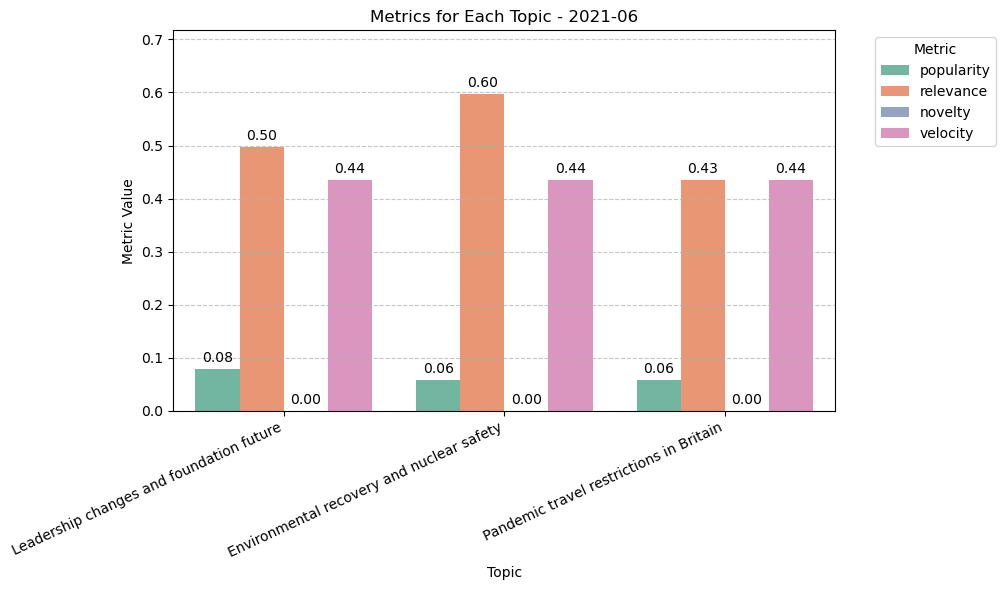

Saved plot: plots//metrics_2021-07.png


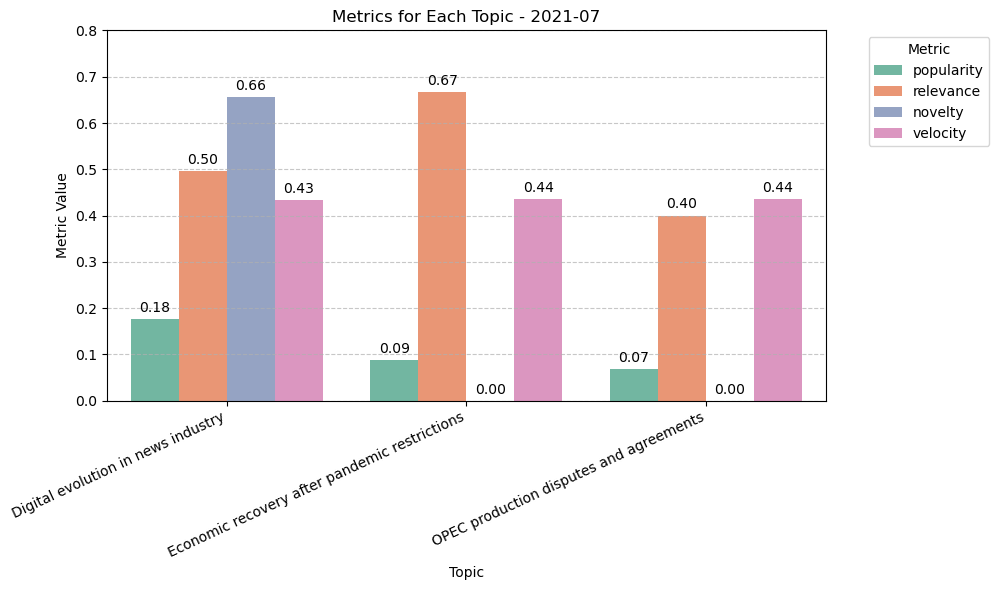

Saved plot: plots//metrics_2021-08.png


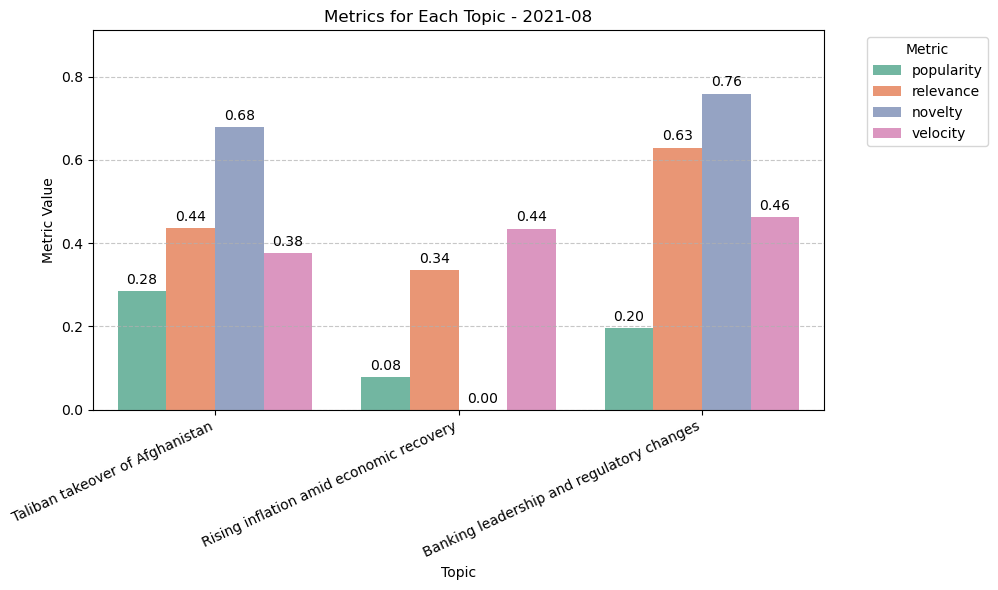

Saved plot: plots//metrics_2021-09.png


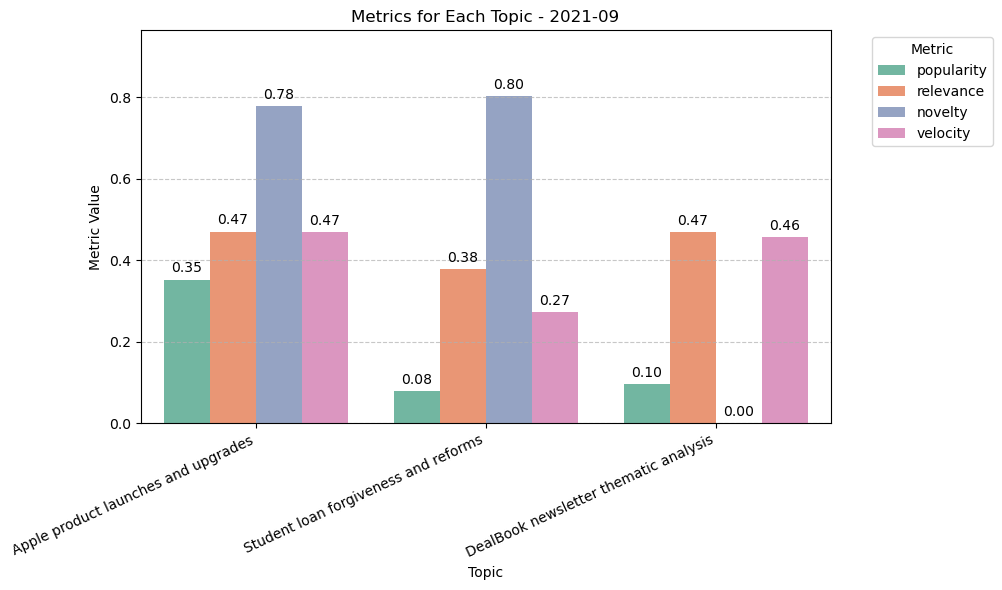

Saved plot: plots//metrics_2021-10.png


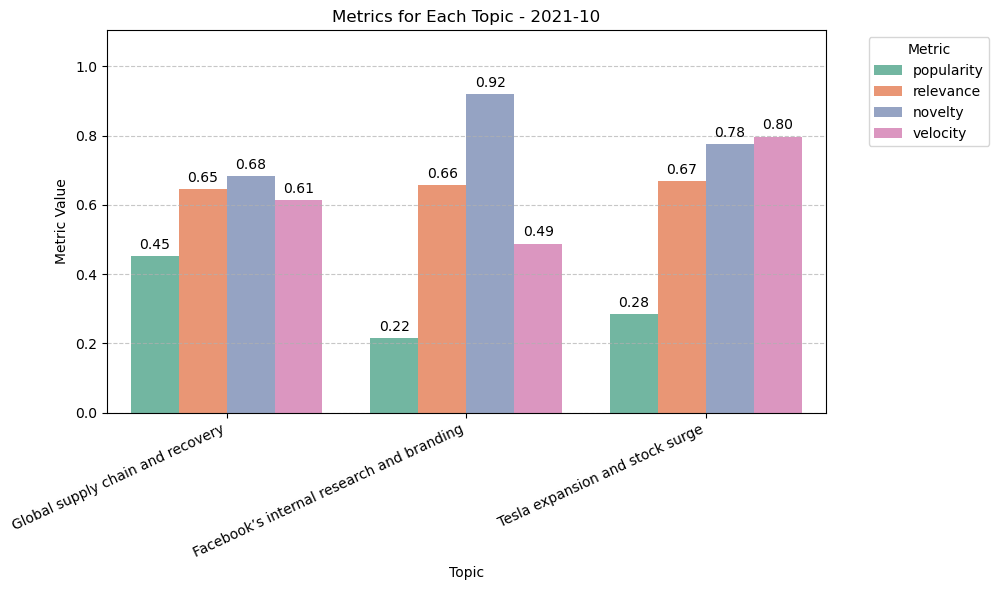

Saved plot: plots//metrics_2021-11.png


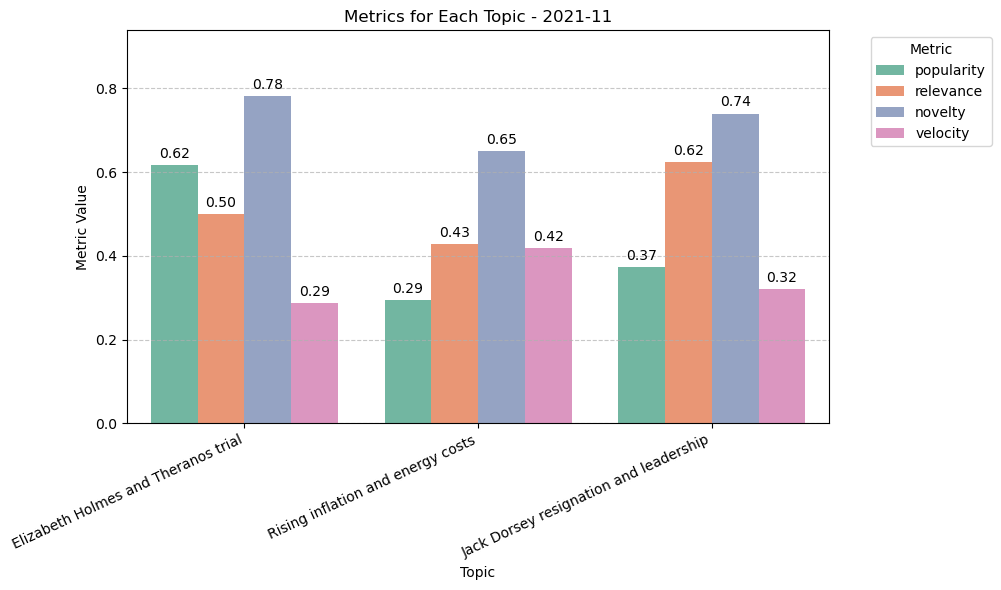

Saved plot: plots//metrics_2021-12.png


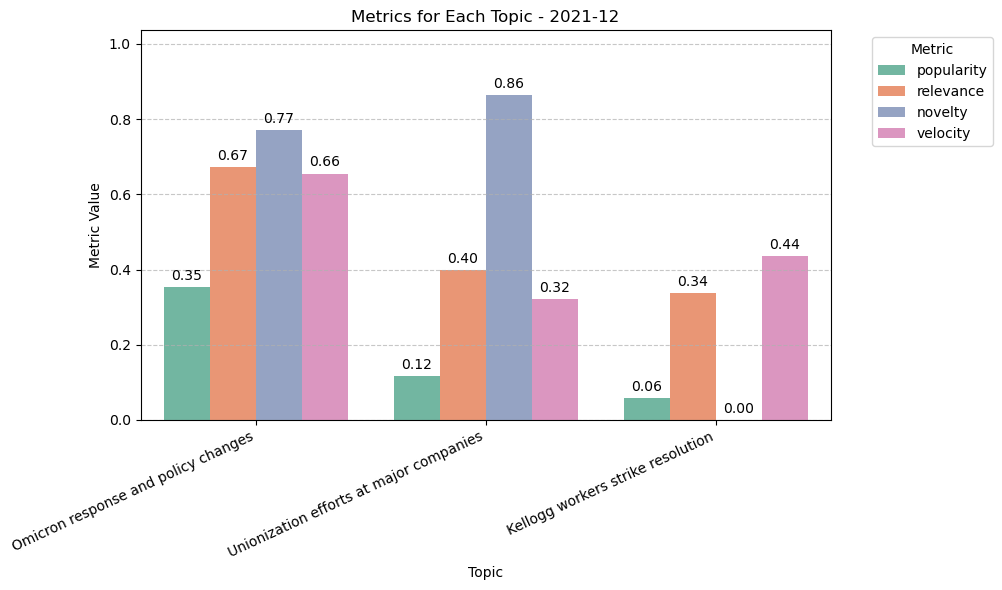

Saved plot: plots//metrics_2022-01.png


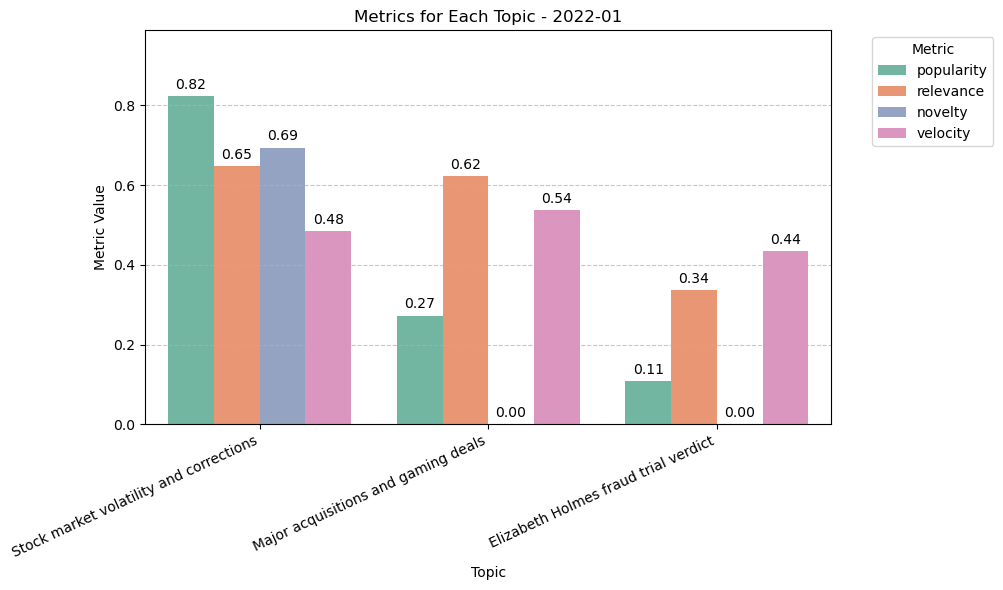

Saved plot: plots//metrics_2022-02.png


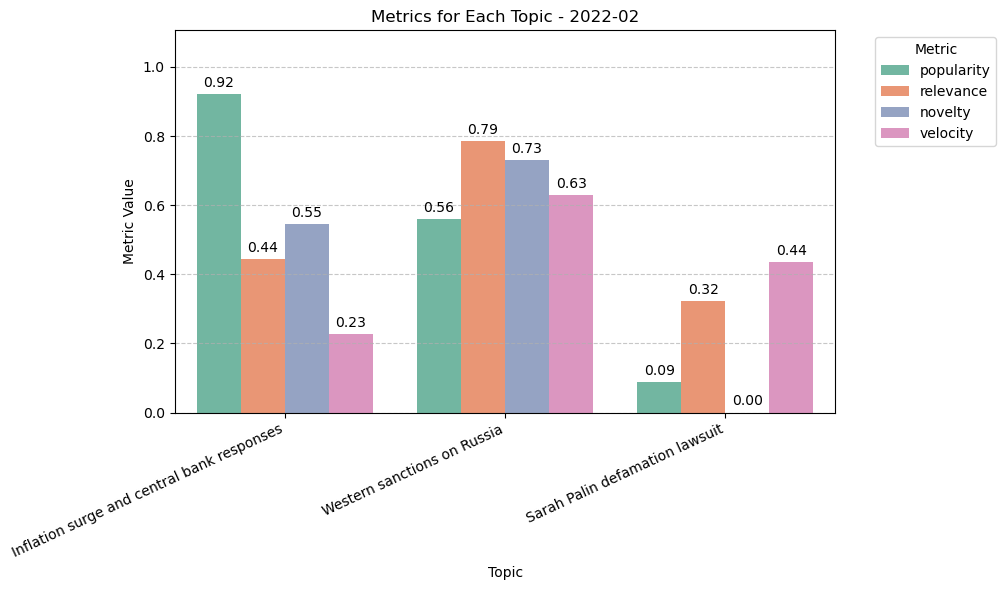

Saved plot: plots//metrics_2022-03.png


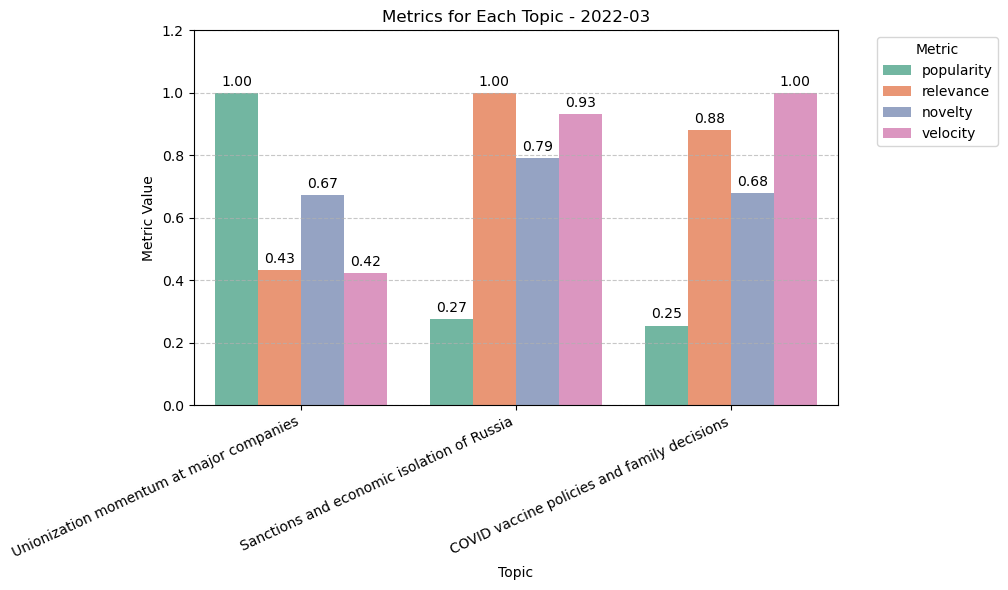

Saved plot: plots//metrics_2022-04.png


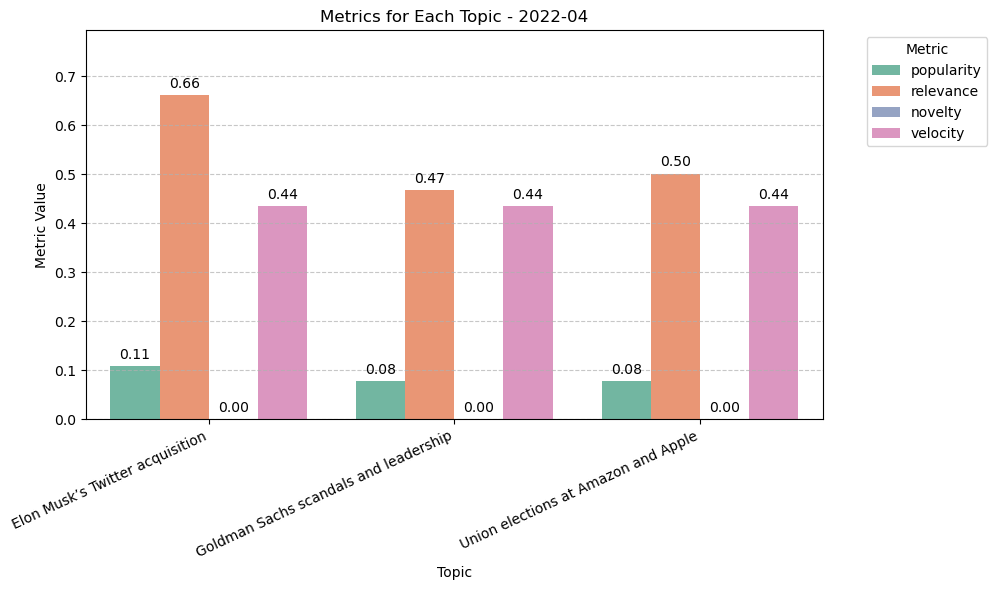

In [341]:
plot_metrics_per_topic_month(result_gt_viz, save_path="plots/")


Saved plot: plots//metric_percentages.png


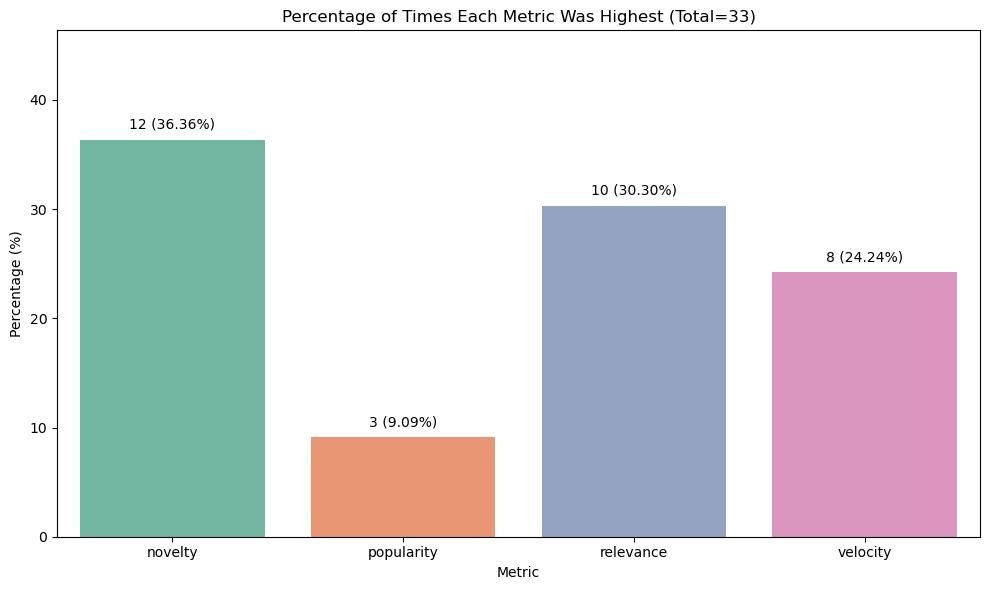

In [342]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_metric_percentages(result_gt_viz, save_path="plots/"):
    """
    1) Turns off FutureWarning.
    2) Calculates how many times each metric (columns in counts_df) was the highest overall,
       sums across all topics, and converts these counts to percentages.
    3) Creates a bar chart showing the percentage for each metric.
    4) Labels each bar with both the count and the percentage.
    5) Adds a title with the total number of experiments (sum of all metric counts).
    6) Saves the plot as a PNG file.

    Args:
        result_gt_viz (pd.DataFrame): DataFrame with topic metrics.
        save_path (str): Directory where images will be saved. Default is "plots/".
    """

    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Find which metric was highest for each row
    result_gt_viz["max_metric"] = (
        result_gt_viz[["popularity", "relevance", "novelty", "velocity"]]
        .idxmax(axis=1)
    )

    # Group by Topic and count how many times each metric is the highest
    counts_df = (
        result_gt_viz
        .groupby("Topic")["max_metric"]
        .value_counts()  # Count occurrences of each metric being the highest
        .unstack(fill_value=0)  # Transform into columns for each metric
    )

    # Turn off FutureWarning
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Sum across columns => total times each metric was highest
    metric_counts = counts_df.sum()

    # Total experiments is the sum of all metric counts
    total_experiments = metric_counts.sum()

    # Convert counts to percentage
    metric_percent = metric_counts / total_experiments * 100

    # Create bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=metric_percent.index, 
        y=metric_percent.values, 
        palette="Set2"
    )

    # Label each bar with both the count and the numeric percentage
    for i, metric in enumerate(metric_percent.index):
        count = metric_counts[metric]
        percentage = metric_percent[metric]
        plt.text(i, percentage + 1, f"{count} ({percentage:.2f}%)", ha='center', fontsize=10)

    # Title includes the total number of experiments
    plt.title(f"Percentage of Times Each Metric Was Highest (Total={int(total_experiments)})")
    plt.xlabel("Metric")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, max(metric_percent.values) + 10)  # Add some space above bars

    plt.tight_layout()

    # Save the figure
    save_filename = f"{save_path}/metric_percentages.png"
    plt.savefig(save_filename, dpi=300, bbox_inches="tight", facecolor="white")

    print(f"Saved plot: {save_filename}")

    plt.show()

plot_metric_percentages(result_gt_viz, save_path="plots/")



In [ ]:
topic_trend = global_topic_doc_info_metrics.drop_duplicates(subset="Name", keep="first")
topic_trend = topic_trend.loc[topic_trend["global_topic_id"].isin(result_gt_viz["global_topic_id"]), :]
topic_trend = topic_trend.rename(columns={
    "popularity_norm": "popularity",
    "relevance_norm": "relevance",
    "novelty_norm": "novelty",
    "velocity_norm": "velocity"
})

topic_trend.columns = ['month','global_topic_id', 'dataset_type', 'popularity', 'relevance','novelty', 'velocity']


In [347]:

import plotly.graph_objects as go
import pandas as pd
import numpy as np

def plot_global_topic_trend(topic_trend, global_topic_id, show_trendlines=True, trend_metric=None, metrics=None):
    """
    Plots a line graph for a selected global topic (specified by global_topic_id) 
    showing the evolution of selected metrics over time for both train and eval data.
    
    The function does not filter on dataset_type; instead, it uses the 'dataset_type' 
    column to set line colors based on the metric:
        - popularity: blue
        - relevance: green
        - novelty: orange
        - velocity: red
    
    If show_trendlines is True, a linear regression trendline is computed and added for 
    either all metrics (if trend_metric is None) or only for the specified metric.
    
    A vertical separation line is placed between March 2022 and April 2022.

    Args:
        topic_trend (pd.DataFrame): DataFrame with columns:
            ['month', 'global_topic_id', 'dataset_type', 'popularity', 
             'relevance', 'novelty', 'velocity'].
        global_topic_id (int): The global topic identifier to visualize.
        show_trendlines (bool): If True, add a trendline (default True).
        trend_metric (str or None): If provided (e.g., "popularity"), only add a trendline
                                    for that metric; otherwise add for all metrics.
        metrics (list of str or None): A list of specific metrics to plot (e.g., ["popularity", "relevance"]).
                                       If None, all four metrics are plotted.
    
    Returns:
        None. Displays the interactive Plotly graph.
    """
    # Filter data for the specified global topic (include both train and eval)
    df = topic_trend[topic_trend['global_topic_id'] == global_topic_id].copy()
    if df.empty:
        print("No data for the given global_topic_id.")
        return

    # Convert 'month' to datetime for proper sorting.
    df['month_dt'] = pd.to_datetime(df['month'], format='%Y-%m')
    df = df.sort_values('month_dt')

    # Create a numeric x-axis for plotting
    df['x'] = np.arange(len(df))
    x_ticks = df['x'].tolist()
    x_labels = df['month'].tolist()

    # Default to all metrics if none are specified
    if metrics is None:
        metrics = ["popularity", "relevance", "novelty", "velocity"]

    # Melt the DataFrame to get long format for selected metrics
    df_long = df.melt(id_vars=["x", "month", "dataset_type"], 
                      value_vars=metrics,
                      var_name="metric", value_name="value")

    # Define color mapping for train data
    metric_colors = {
        "popularity": "blue",
        "relevance": "green",
        "novelty": "orange",
        "velocity": "red"
    }

    fig = go.Figure()

    # Group data by dataset_type and metric so that train and eval lines are separate
    groups = df_long.groupby(["dataset_type", "metric"])

    for (dt, metric), group in groups:
        group = group.sort_values("x")
        x_vals = group["x"].values
        y_vals = group["value"].values

        # Use the metric's color mapping for both train and eval data
        color = metric_colors.get(metric, "black")

        # Add the actual metric line with markers
        fig.add_trace(go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='lines+markers',
            name=f"{metric} ({dt})",
            marker=dict(size=6),
            line=dict(color=color, width=2),
            opacity=0.6
        ))

        # Add trendline if requested
        if show_trendlines and (trend_metric is None or metric == trend_metric):
            if len(x_vals) > 1:
                slope, intercept = np.polyfit(x_vals, y_vals, 1)
                trend_y = slope * x_vals + intercept
                fig.add_trace(go.Scatter(
                    x=x_vals,
                    y=trend_y,
                    mode='lines',
                    name=f"{metric} ({dt} trend)",
                    line=dict(color=color, dash="dash", width=2)
                ))

    # Add vertical separation line between March 2022 and April 2022
    if "2022-03" in df["month"].values and "2022-04" in df["month"].values:
        separation_index = df[df["month"] == "2022-03"]["x"].max() + 0.5
        fig.add_shape(
            type="line",
            x0=separation_index,
            x1=separation_index,
            y0=df_long["value"].min(),
            y1=df_long["value"].max(),
            line=dict(color="black", width=2, dash="dot")
        )

    fig.update_layout(
        title=f"Global Topic {global_topic_id} Trend",
        xaxis_title="Month",
        yaxis_title="Metric Value",
        xaxis=dict(
            tickmode='array',
            tickvals=x_ticks,
            ticktext=x_labels
        ),
        template="plotly_white",
        legend_title="Metric (Dataset)",
        width=1200,
        height=800
    )

    fig.show()


In [ ]:
# filtered_df.groupby("global_topic_id").global_topic_id.size().sort_values(ascending=False)

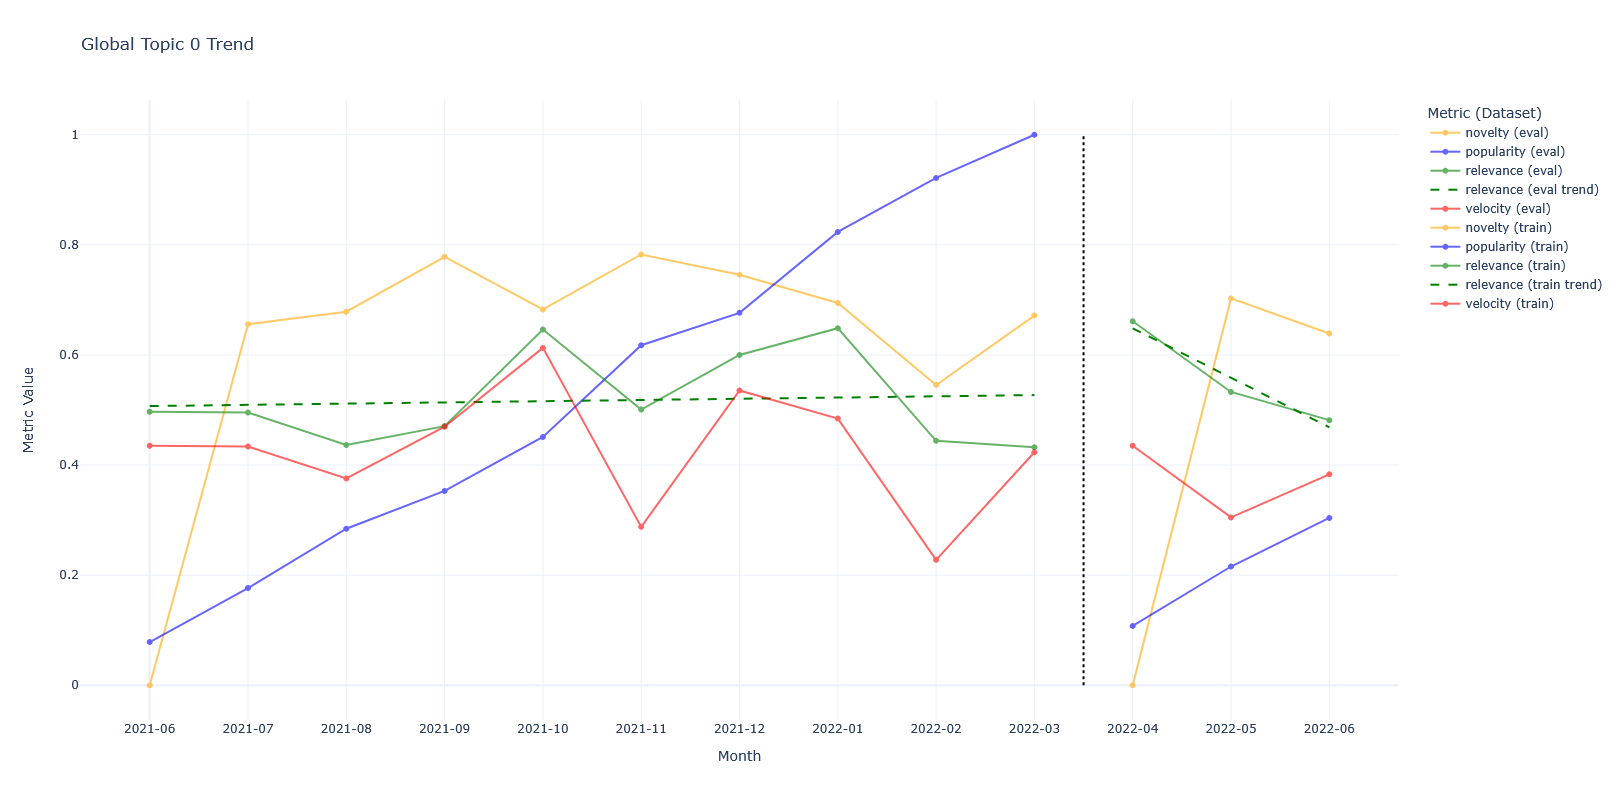

In [349]:
plot_global_topic_trend(topic_trend, global_topic_id=0, show_trendlines=True, trend_metric="relevance", metrics=["popularity", "relevance", "novelty", "velocity"])

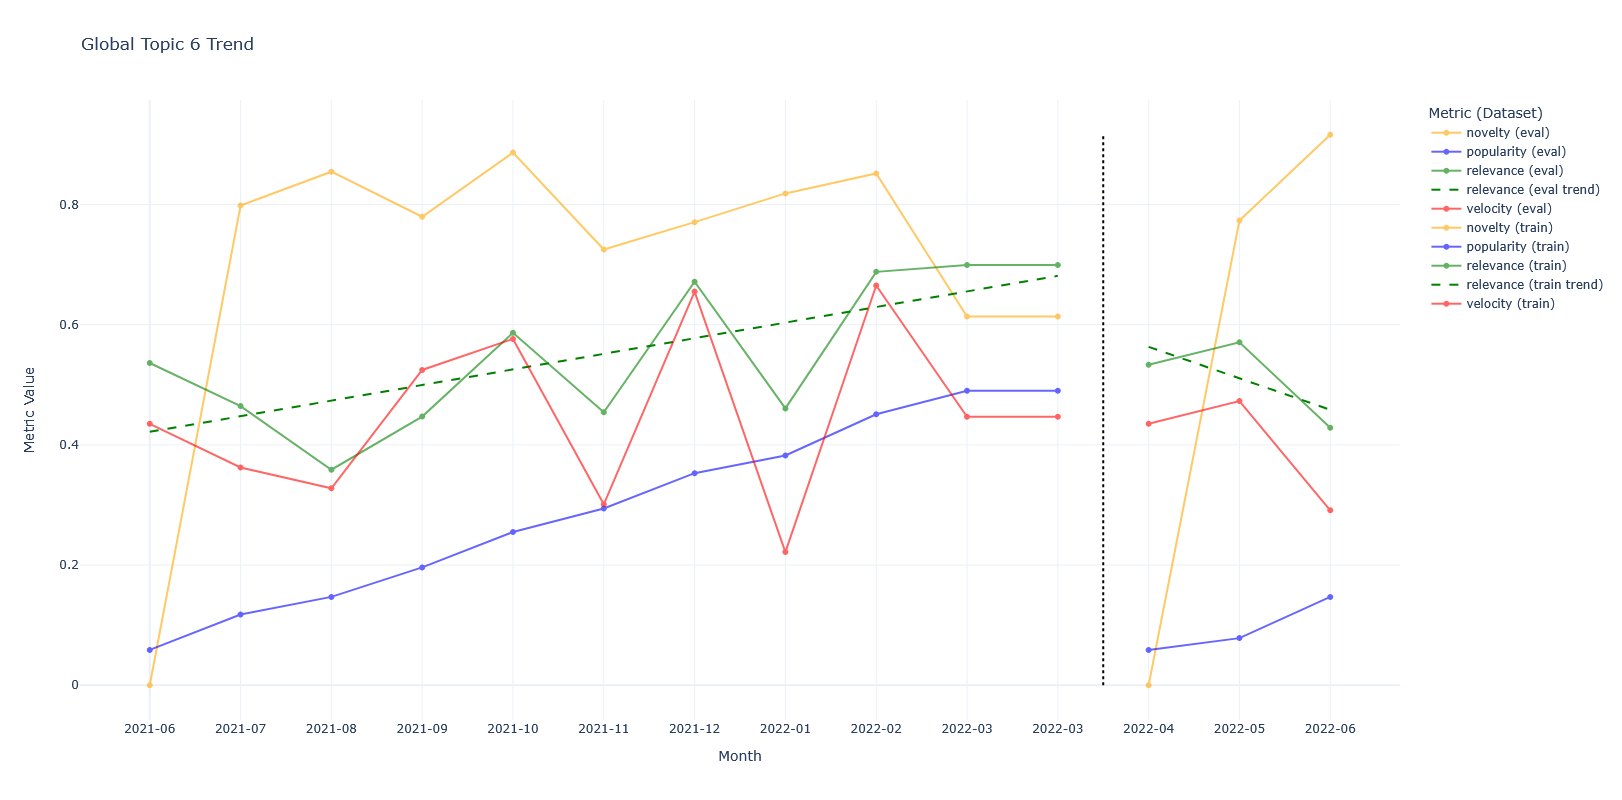

In [353]:
plot_global_topic_trend(topic_trend, global_topic_id=6, show_trendlines=True, trend_metric="relevance", metrics=["popularity", "relevance", "novelty", "velocity"])

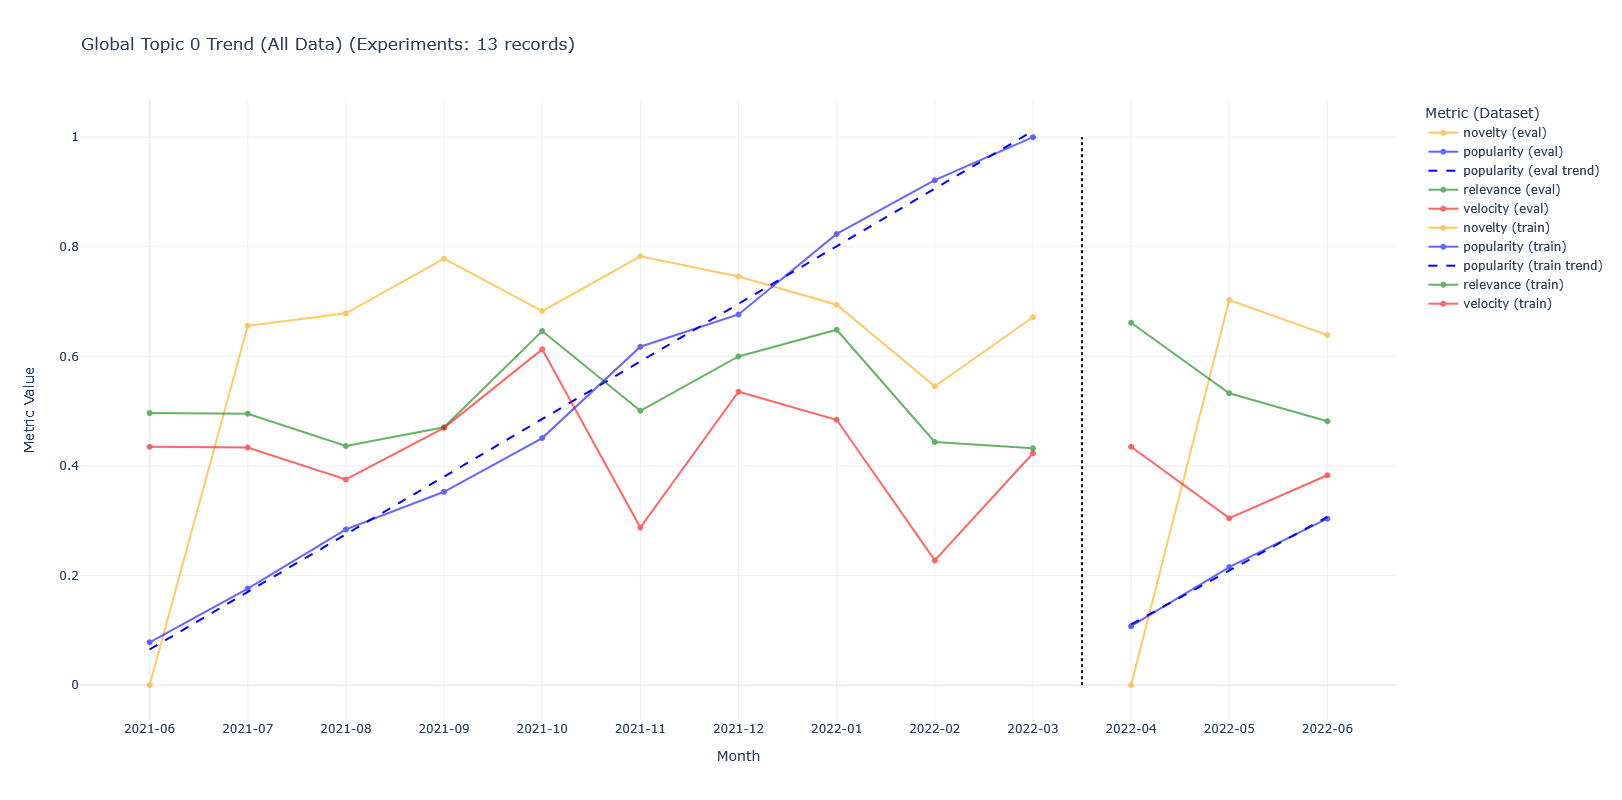

In [332]:
plot_global_topic_trend(topic_trend, global_topic_id=0, show_trendlines=True, trend_metric="popularity", metrics=["popularity", "relevance", "novelty", "velocity"])

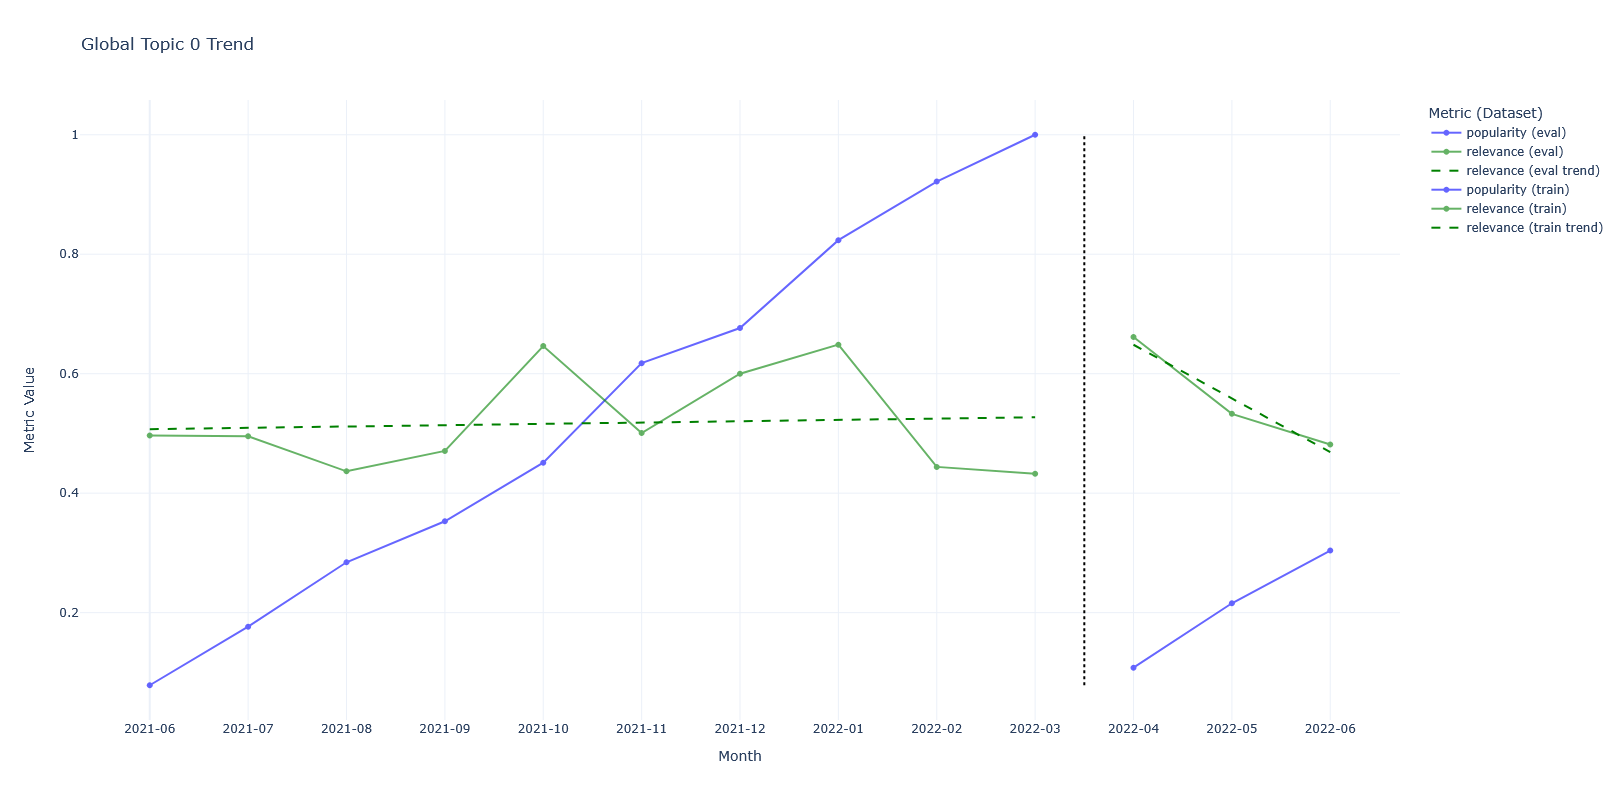

In [354]:
plot_global_topic_trend(topic_trend, global_topic_id=0, show_trendlines=True, trend_metric="relevance", metrics=["popularity", "relevance"])

In [ ]:
import pandas as pd

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)


# Find topics that appear in multiple months
repeated_topics = topic_trend.groupby("global_topic_id")["month"].nunique()

repeated_topics = repeated_topics[repeated_topics > 1].index

# Filter the DataFrame to include only repeated topics
filtered_df = topic_trend[topic_trend["global_topic_id"].isin(repeated_topics)]

import plotly.graph_objects as go
import pandas as pd
import numpy as np

def plot_topic_metric_over_time(df, metric="popularity"):
    """
    Plots a line graph for each unique combination of global_topic_id and dataset_type,
    showing the evolution of the specified metric over time.
    
    For each (global_topic_id, dataset_type) group, the metric is plotted as a line with:
      - Smaller markers (size=6)
      - Trace opacity set to 0.6
    Train lines are colored green and eval lines are dark grey.
    
    Args:
        df (pd.DataFrame): DataFrame with columns: ['month', 'global_topic_id', 'dataset_type', metric].
        metric (str): The metric to plot (default "popularity").
    
    Returns:
        None. Displays an interactive Plotly figure.
    """
    # Convert 'month' to datetime if necessary and sort
    if not pd.api.types.is_datetime64_any_dtype(df["month"]):
        df["month_dt"] = pd.to_datetime(df["month"], format="%Y-%m")
    else:
        df["month_dt"] = df["month"]
    df = df.sort_values("month_dt")
    
    # Define color mapping for dataset_type
    color_map = {"train": "green", "eval": "darkgrey"}
    
    # Create a Plotly figure
    fig = go.Figure()
    
    # Group by global_topic_id and dataset_type to get separate traces
    groups = df.groupby(["global_topic_id", "dataset_type"])
    
    for (topic, dt), group in groups:
        group = group.sort_values("month_dt")
        fig.add_trace(go.Scatter(
            x = group["month_dt"],
            y = group[metric],
            mode = "lines+markers",
            name = f"Topic {topic} ({dt})",
            marker = dict(size=6),
            line = dict(color=color_map.get(dt, "blue"), width=2),
            opacity = 0.6
        ))
    
    fig.update_layout(
        title = f"Trend of {metric.capitalize()} Over Time for All Global Topics",
        xaxis_title = "Month",
        yaxis_title = metric.capitalize(),
        template = "plotly_white",
        width = 1200,
        height = 800,
        legend_title = "Topic (Dataset)"
    )
    
    fig.show()

# Example usage:
# Assuming 'topic_trend_df' is your DataFrame with columns:
# ['month','global_topic_id', 'dataset_type', 'popularity', 'relevance', 'novelty', 'velocity']
# plot_topic_metric_over_time(topic_trend_df, metric="popularity")


C:\Users\sinab\AppData\Local\Temp\ipykernel_22980\1958011526.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



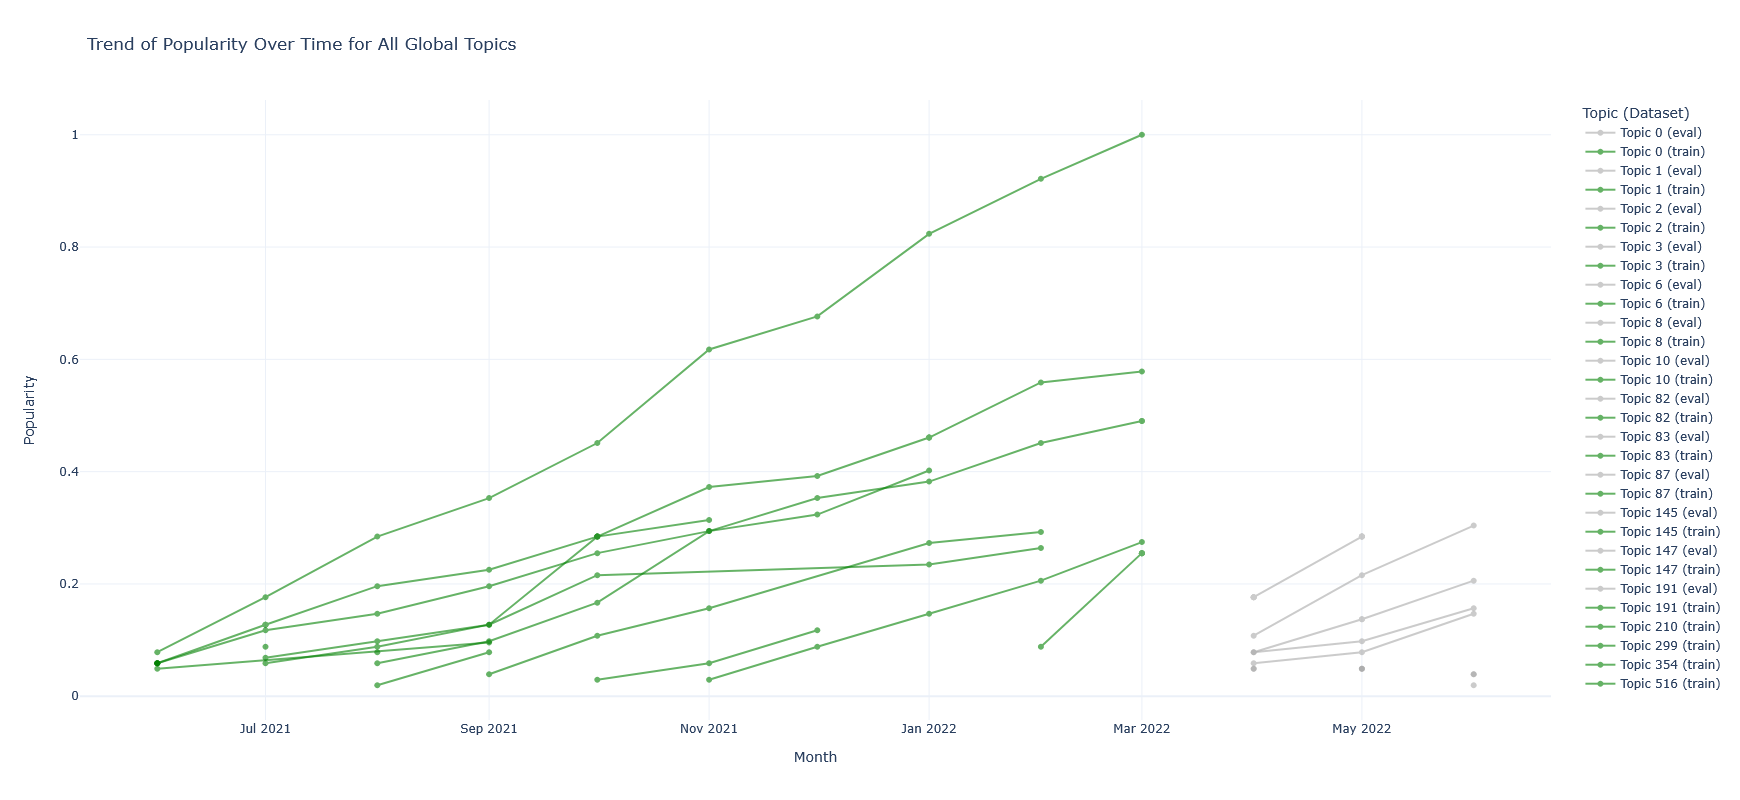

In [246]:
plot_topic_metric_over_time(filtered_df, metric="popularity")

In [247]:
filtered_df.global_topic_id.unique()

array([  0,   1,   2,   3,   6,   8,  10,  82,  83,  87, 145, 147, 191,
       210, 299, 354, 516], dtype=int64)

In [249]:
filtered_df[filtered_df.global_topic_id==145]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,month,doc_index_in_month,original_text,dataset_type,global_topic_id,global_topic_title,popularity,relevance,novelty,velocity,month_dt
842,marriott international’s sales more than doubl...,1,1_inflation_july_rose_recovery,"[inflation, july, rose, recovery, rapid, pande...",[the biden administration on friday said it ex...,inflation - july - rose - recovery - rapid - p...,1.0,False,2021-08,21,marriott international’s sales more than doubl...,train,145,inflation_july_rose,0.078431,0.335930,0.0,0.435072,2021-08-01
3366,sarah palin lost her bid for a new trial in he...,19,19_jury_trumps_post_her,"[jury, trumps, post, her, company, took, washi...",[when sally buzbee joined the washington post ...,jury - trumps - post - her - company - took - ...,1.0,True,2022-06,0,sarah palin lost her bid for a new trial in he...,eval,145,jury_trumps_post,0.039216,0.540387,0.0,0.435072,2022-06-01


C:\Users\sinab\AppData\Local\Temp\ipykernel_22980\1958011526.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



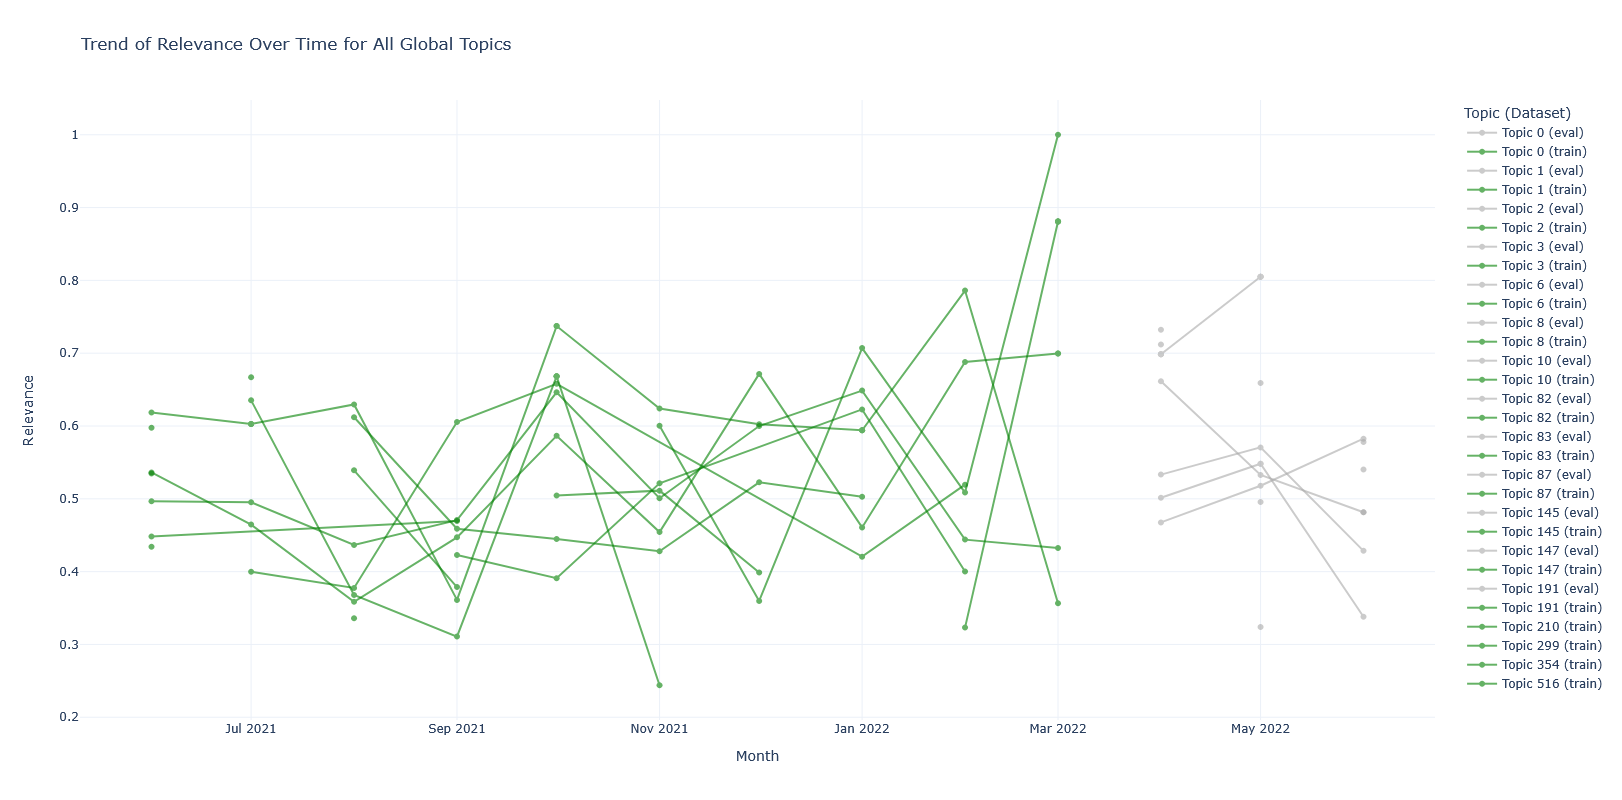

In [248]:
plot_topic_metric_over_time(filtered_df, metric="relevance")

C:\Users\sinab\AppData\Local\Temp\ipykernel_22980\1958011526.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



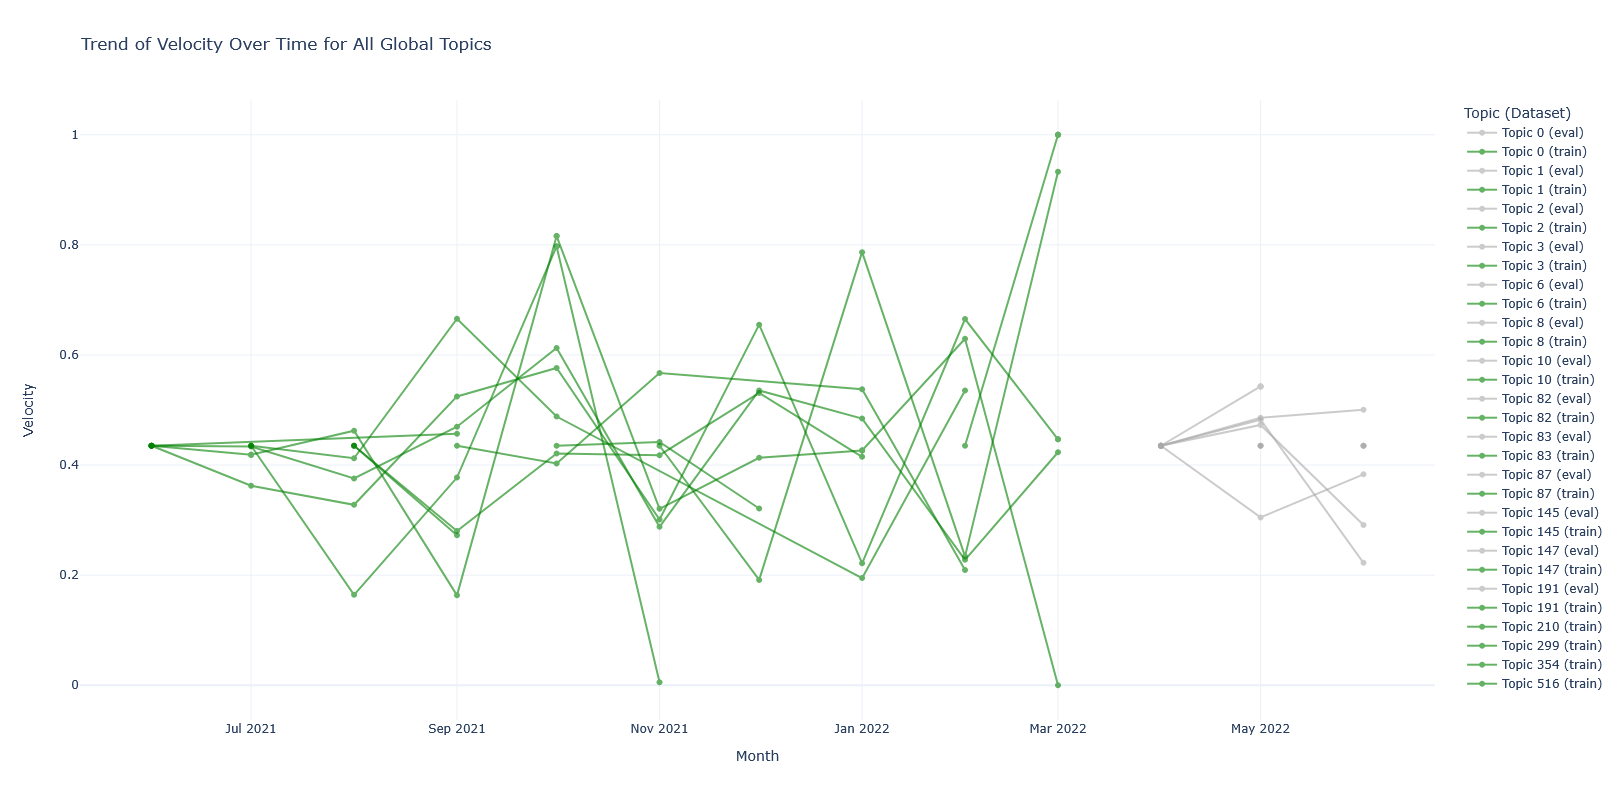

In [252]:
plot_topic_metric_over_time(filtered_df, metric="velocity")

In [317]:
filtered_df.global_topic_id.unique()

array([  0,   1,   2,   3,   6,   8,  10,  82,  83,  87, 145, 147, 191,
       210, 299, 354, 516], dtype=int64)

In [318]:
filtered_df.shape

(111, 19)

C:\Users\sinab\AppData\Local\Temp\ipykernel_22980\1958011526.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



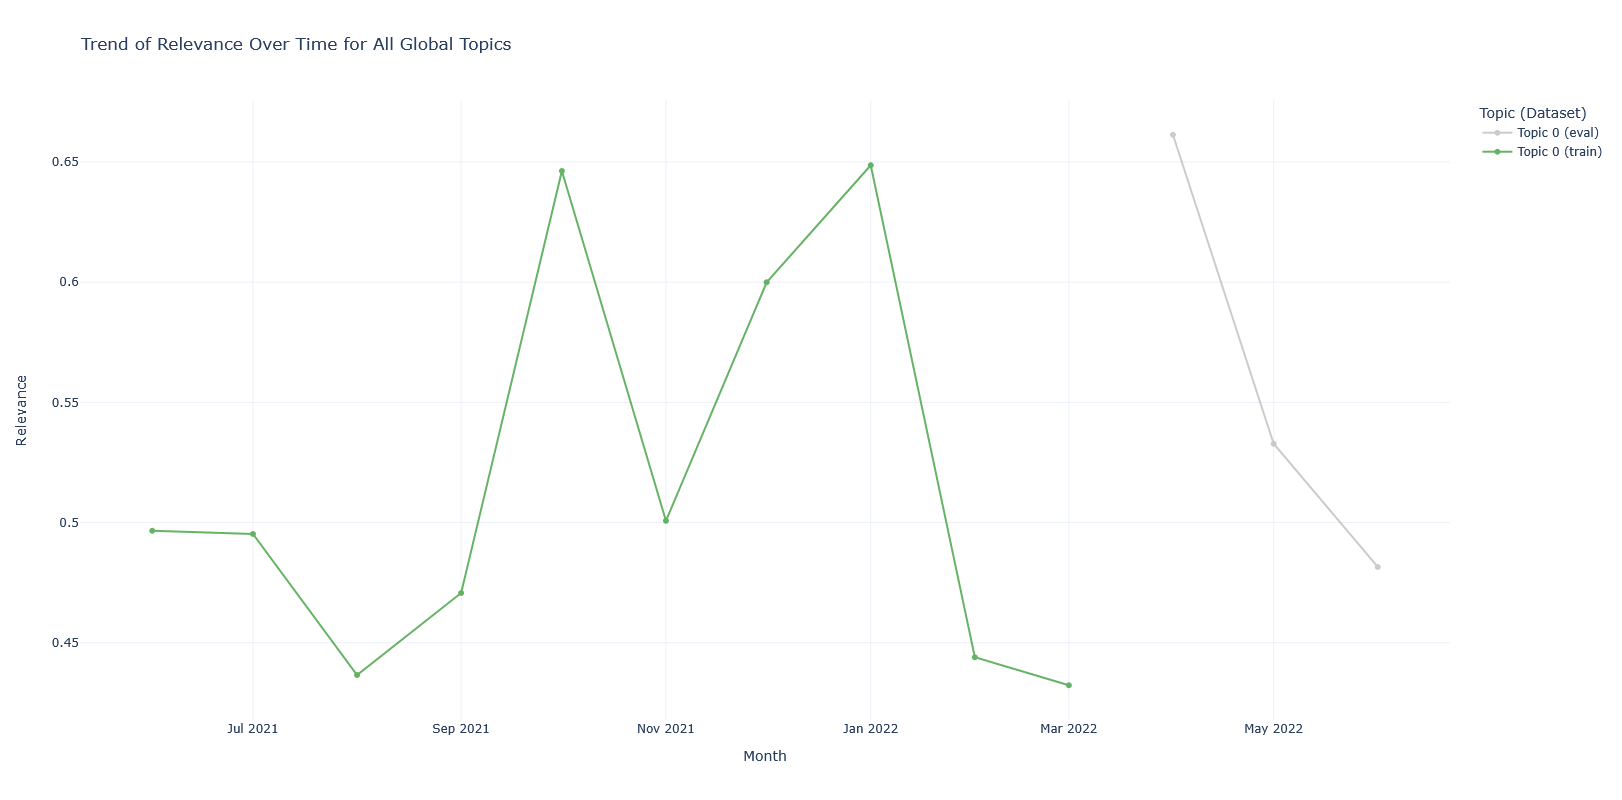

In [320]:
plot_topic_metric_over_time(filtered_df[filtered_df.global_topic_id==0], metric="relevance")

C:\Users\sinab\AppData\Local\Temp\ipykernel_22980\1958011526.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



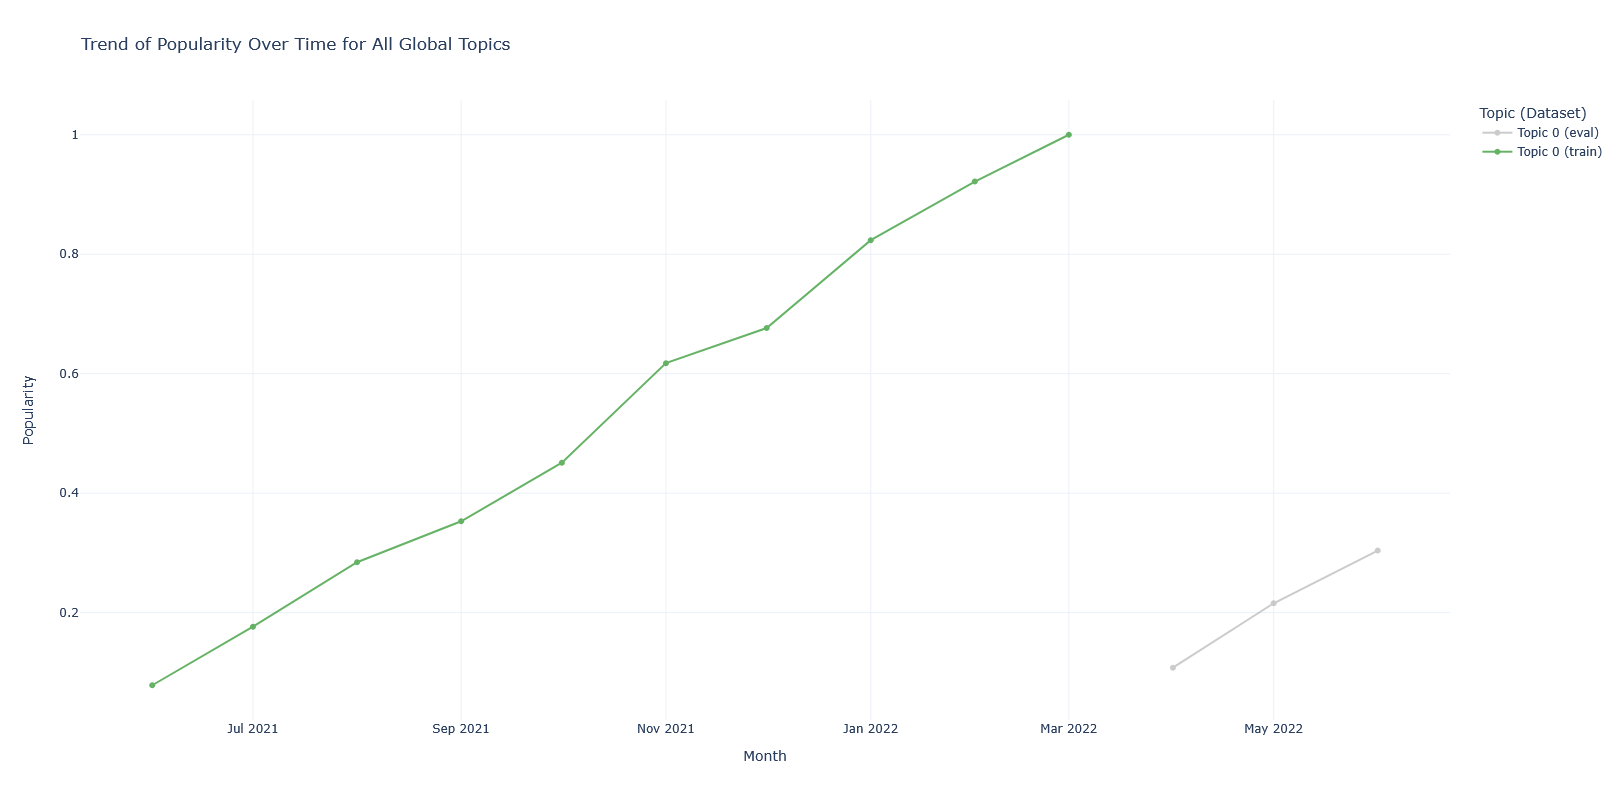

In [326]:
plot_topic_metric_over_time(filtered_df[filtered_df.global_topic_id==0], metric="popularity")

## Result Quantitative

Saved plot: plots//evaluation_metrics.png


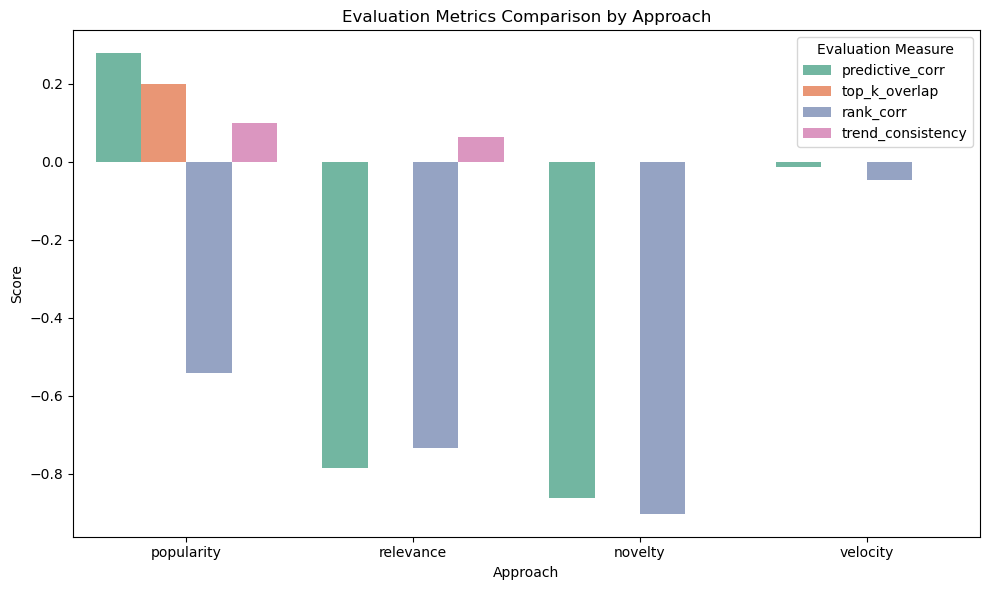

In [355]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_evaluation_bars(eval_df, save_path="plots/"):
    """
    Creates a bar plot comparing different evaluation metrics across approaches 
    and saves it as a PNG file.

    Args:
        eval_df (pd.DataFrame): DataFrame containing evaluation metrics with columns:
            ['approach', 'predictive_corr', 'top_k_overlap', 'rank_corr', 'trend_consistency']
        save_path (str): Directory where the image will be saved. Default is "plots/".
    """

    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Melt the DataFrame so that each evaluation measure becomes a category
    df_melted = eval_df.melt(
        id_vars="approach", 
        value_vars=["predictive_corr", "top_k_overlap", "rank_corr", "trend_consistency"],
        var_name="Measure", 
        value_name="Value"
    )

    # Create bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_melted, x="approach", y="Value", hue="Measure", palette="Set2")
    
    # Set titles and labels
    plt.title("Evaluation Metrics Comparison by Approach")
    plt.ylabel("Score")
    plt.xlabel("Approach")
    plt.legend(title="Evaluation Measure")

    plt.tight_layout()

    # Save the figure
    save_filename = f"{save_path}/evaluation_metrics.png"
    plt.savefig(save_filename, dpi=300, bbox_inches="tight", facecolor="white")

    print(f"Saved plot: {save_filename}")

    # Show the plot
    plt.show()
plot_evaluation_bars(df_eval, save_path="plots/")


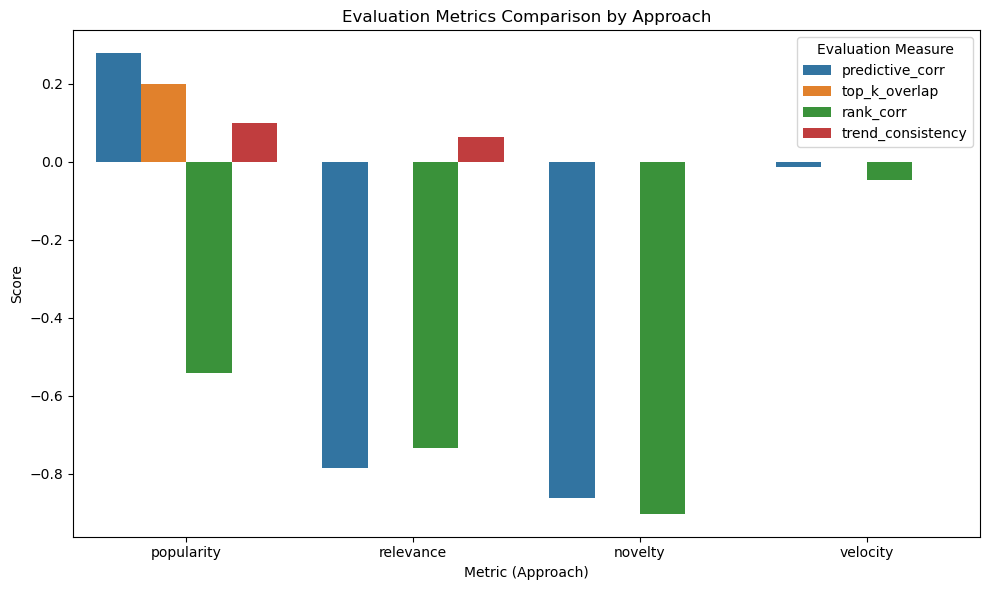

In [301]:
plot_evaluation_bars(df_eval)

In [357]:
df_eval

,approach,predictive_corr,top_k_overlap,rank_corr,trend_consistency
0,popularity,0.278514,0.2,-0.541374,0.10000
1,relevance,-0.785733,0.0,-0.733596,0.06383
2,novelty,-0.861743,0.0,-0.903089,0.00000
3,velocity,-0.014220,0.0,-0.047268,0.00000


In [333]:
def print_summary_table(eval_df):
    # Order the columns as desired
    summary = eval_df[["approach", "predictive_corr", "top_k_overlap", "rank_corr", "trend_consistency"]]
    print("=== Evaluation Summary ===")
    print(summary.to_string(index=False))
    
# Example usage:
# print_summary_table(df_eval)


In [334]:
print_summary_table(df_eval)

=== Evaluation Summary ===
  approach  predictive_corr  top_k_overlap  rank_corr  trend_consistency
popularity         0.278514            0.2  -0.541374            0.10000
 relevance        -0.785733            0.0  -0.733596            0.06383
   novelty        -0.861743            0.0  -0.903089            0.00000
  velocity        -0.014220            0.0  -0.047268            0.00000


In [304]:
import pandas as pd

def plot_classification_confusion(top10_df):
    # Create a cross-tabulation of train_class vs. eval_class for the top10 topics across all approaches.
    # You can do this per approach or for all combined.
    confusion = pd.crosstab(top10_df["train_class"], top10_df["eval_class"], margins=True)
    
    print("=== Classification Confusion Matrix (Top-10 Topics) ===")
    print(confusion)
    
    # Optional: plot a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion.iloc[:-1, :-1], annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix: Train vs Eval Classification (Top-10 Topics)")
    plt.ylabel("Train Classification")
    plt.xlabel("Eval Classification")
    plt.show()

# Example usage:
# plot_classification_confusion(df_top10)


=== Classification Confusion Matrix (Top-10 Topics) ===
eval_class     noise  strong signal  weak signal  All
train_class                                          
strong signal      2              7           31   40
All                2              7           31   40


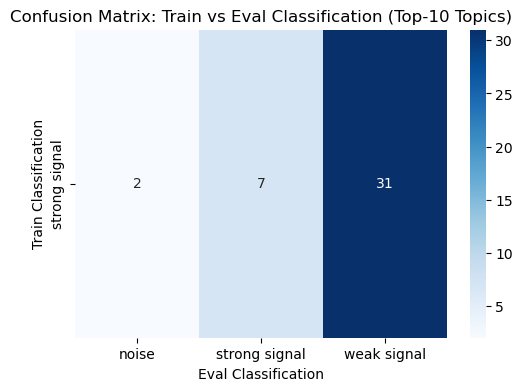

In [305]:
plot_classification_confusion(df_top10)

In [306]:
def plot_strong_topic_trends(combined_df, approach="popularity", num_topics=3):
    """
    Plots the monthly evolution for a few topics that were classified as 'strong signal'
    in the final training month.
    """
    # Get training data from the final training month
    train_months = sorted(combined_df.loc[combined_df["status"]=="train", "month"].unique())
    last_train_month = train_months[-1]
    
    train_slice = combined_df[(combined_df["status"]=="train") & (combined_df["month"]==last_train_month)]
    # Compute thresholds from the training slice for classification
    values = train_slice[approach].dropna().values
    p10 = np.percentile(values, 10)
    p50 = np.percentile(values, 50)
    
    def classify(value):
        if value < p10:
            return "noise"
        elif value <= p50:
            return "weak signal"
        else:
            return "strong signal"
    
    # Label training slice
    train_slice = train_slice.copy()
    train_slice["train_class"] = train_slice[approach].apply(classify)
    
    # Pick topics classified as "strong signal"
    strong_topics = train_slice[train_slice["train_class"]=="strong signal"]["global_topic_id"].unique()
    if len(strong_topics) == 0:
        print("No strong topics found in the final training month for approach:", approach)
        return
    
    # Limit to a few topics for clarity
    selected_topics = strong_topics[:num_topics]
    
    # Get all monthly data for these topics
    trend_data = combined_df[combined_df["global_topic_id"].isin(selected_topics)]
    
    plt.figure(figsize=(10, 6))
    for tid in selected_topics:
        topic_data = trend_data[trend_data["global_topic_id"]==tid]
        # Sort by month (assuming month is in YYYY-MM format)
        topic_data = topic_data.sort_values("month")
        plt.plot(topic_data["month"], topic_data[approach], marker='o', label=f"Topic {tid}")
    
    plt.title(f"Trend Evolution of Selected 'Strong Signal' Topics ({approach})")
    plt.xlabel("Month")
    plt.ylabel(approach.capitalize())
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_strong_topic_trends(combined_df, approach="popularity", num_topics=3)


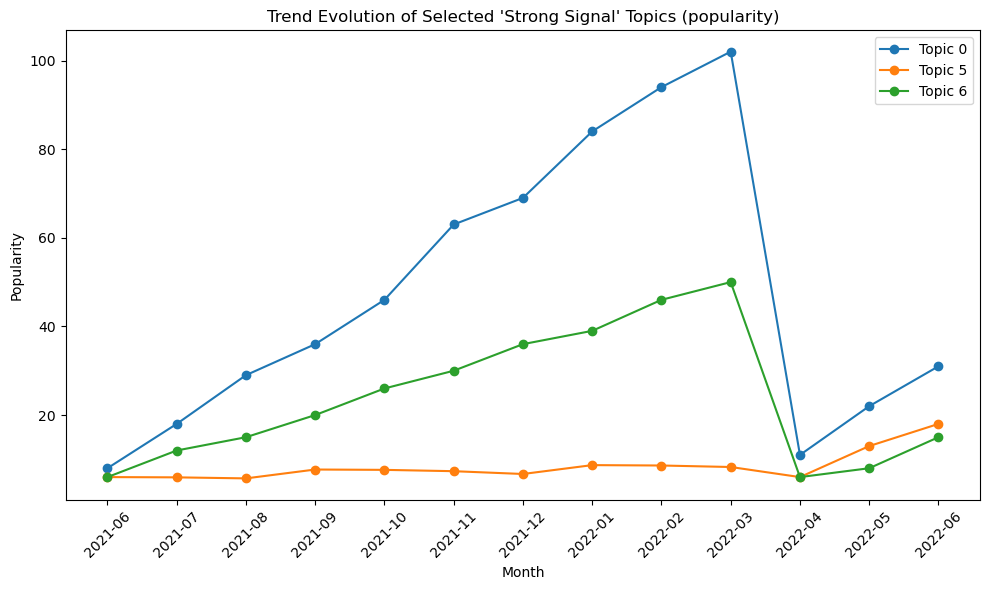

In [307]:
plot_strong_topic_trends(df_result_pop_all, approach="popularity", num_topics=3)

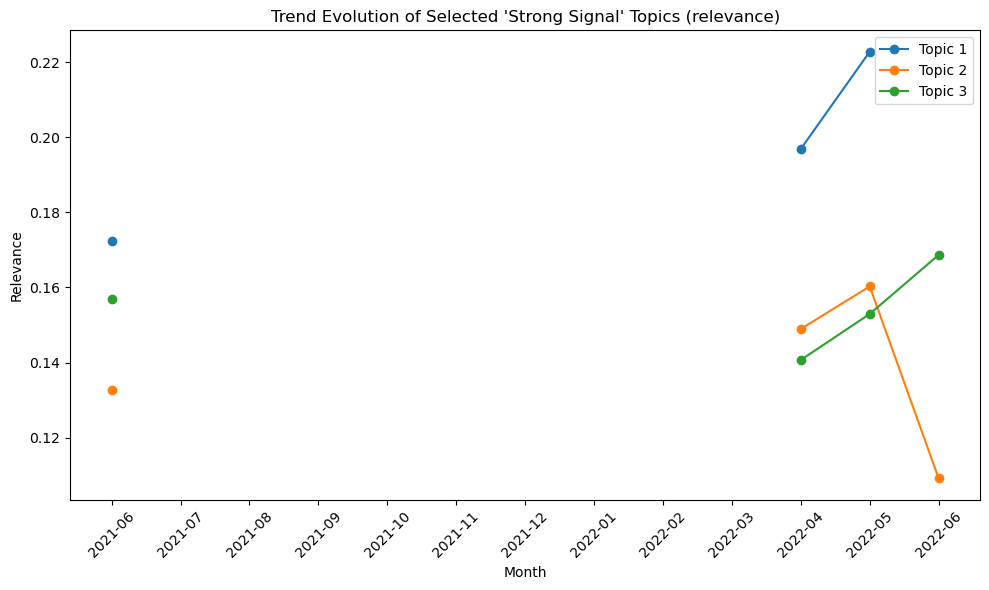

In [308]:
plot_strong_topic_trends(df_result_pop_all, approach="relevance", num_topics=3)

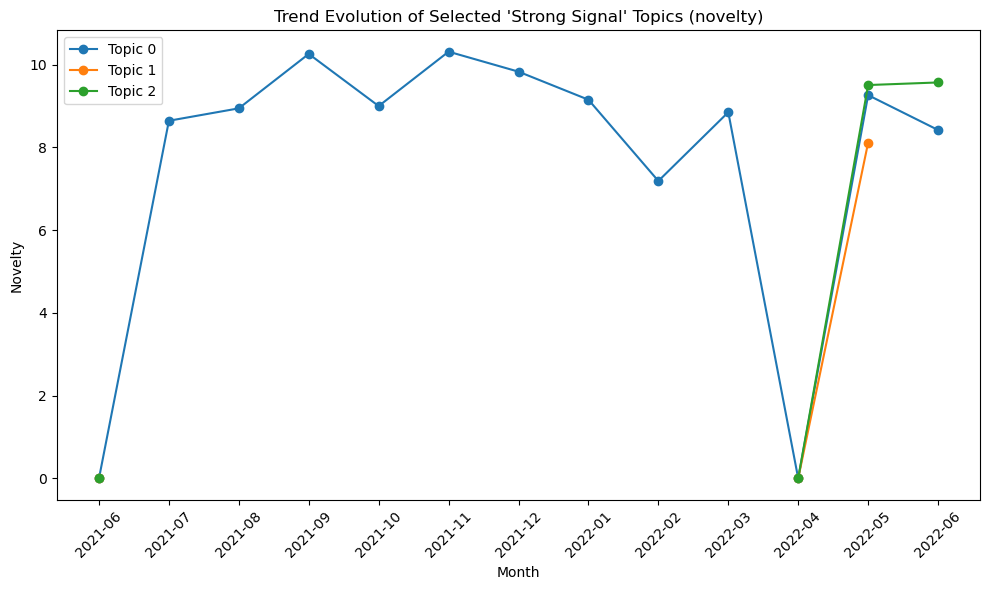

In [309]:
plot_strong_topic_trends(df_result_pop_all, approach="novelty", num_topics=3)

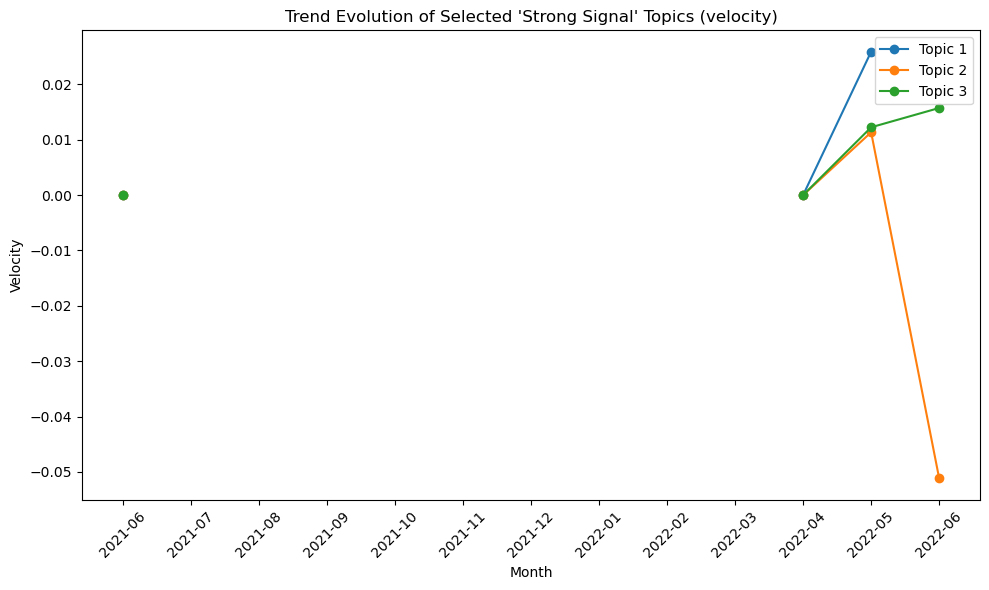

In [310]:
plot_strong_topic_trends(df_result_pop_all, approach="velocity", num_topics=3)

In [311]:
def print_written_summary(eval_df):
    summary_lines = []
    for index, row in eval_df.iterrows():
        approach = row["approach"]
        pred_corr = row["predictive_corr"]
        topk_overlap = row["top_k_overlap"]
        rank_corr = row["rank_corr"]
        trend_consistency = row["trend_consistency"]
        
        line = (f"Metric: {approach.capitalize()} -- Predictive Corr: {pred_corr:.2f}, "
                f"Top-k Overlap: {topk_overlap:.2f}, Rank Corr: {rank_corr:.2f}, "
                f"Trend Consistency: {trend_consistency:.2f}")
        summary_lines.append(line)
    
    print("=== Written Summary of Evaluation ===")
    for line in summary_lines:
        print(line)

# Example usage:
# print_written_summary(df_eval)


In [312]:
print_written_summary(df_eval)

=== Written Summary of Evaluation ===
Metric: Popularity -- Predictive Corr: 0.28, Top-k Overlap: 0.20, Rank Corr: -0.54, Trend Consistency: 0.10
Metric: Relevance -- Predictive Corr: -0.79, Top-k Overlap: 0.00, Rank Corr: -0.73, Trend Consistency: 0.06
Metric: Novelty -- Predictive Corr: -0.86, Top-k Overlap: 0.00, Rank Corr: -0.90, Trend Consistency: 0.00
Metric: Velocity -- Predictive Corr: -0.01, Top-k Overlap: 0.00, Rank Corr: -0.05, Trend Consistency: 0.00
